# Feature-based analysis 

This is one of the key analysis to compare different experimental conditions and to guide future insights and reports. After analyzing the raw data and obtaining a summarized metric set, we can consider each measurement as a feature in a dataset and understand which of these statistical features and measurements is most informative and better differentiates the different experimental conditions (*feature importance* analysis) or we can use this dataset to train machine learning models to predict experimental conditions (*classification* analysis) or to obtain a suitable visualization of the data structure (*geometric* analysis).

These analysis start with loading a pre-computed DataFrame with all the metrics computed for all experimental conditions. This can be obtained with the tools provided in MEA-flow (see examples in [activity_analysis.ipynb](activity_analysis.ipynb)) or any external tools that pre-processed and analyzed the dataset. When considered like this, we have a dataset with `n_samples` (unique observations or measurements) and `n_features` (set of metrics).

The most critical aspect (from a machine learning standpoint) is that it is not advisable to have a single measurement per condition. We consider a measurement as a `sample` in our dataset so we need to have multiple measurements/samples per condition (either multiple recordings, multiple wells, or multiple time windows). Consider, for example, that we use the entire metric set available in MEA-flow, comprising 70+ features (comprising metrics of activity, regularity, synchrony, burstiness, etc.). If we only have one measurement per condition (e.g. mean firing rate for condition 1), this dataset suffers from the **curse of dimensionality** (`n_samples` << `n_features`) and is not informative enough to perform a proper analysis. Many of the ML algorithms will fail in these circumstances and those that don't will provide very unstable results. 

In [activity_analysis.ipynb](activity_analysis.ipynb), we demonstrate how we can augment our dataset to mitigate this effect by performing different groupings of the data:
1. Grouping only by condition → 1 sample per feature per condition ❌ 
2. Grouping by condition and well → 1 sample per feature per condition per well (4x samples per condition) ⚠️
3. Grouping by condition and time → 1 sample per feature per condition per time window (n_time_windows samples per condition) ✅
4. Grouping by condition and single electrode → 1 sample per feature per condition per electrode (n_electrodes samples per condition) ✅

---


## 1. Exploratory analysis - visualizing the structure of the data

A good way to start analyzing the data is to visualize its structure. This can help identify patterns, clusters, and relationships between variables. As mentioned above, having a single datapoint per condition is not ideal for visualization methods. So, we will ignore the `global` dataset and use the `temporal` one instead, where each metric was applied to each time window separately, yielding a richer dataset.

### 1.1. Dimensionality reduction and manifold learning

The first class of methods attempts to reduce the dimensionality of the data while preserving its structure. This can help visualize the data and identify patterns. A complete explanation of the methods implemented in MEA-flow is provided in [MANIFOLD_METHODS_DOCUMENTATION.md](MANIFOLD_METHODS_DOCUMENTATION.md).

In [1]:
import matplotlib.pyplot as plt
from mea_flow.analysis import analyze_feature_space


ImportError: /home/neuro/miniconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.32' not found (required by /usr/lib/python3/dist-packages/kiwisolver/_cext.cpython-312-x86_64-linux-gnu.so)

=== Feature Space Manifold Analysis ===
Data shape: (180, 47) (180 samples, 50 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Applying PCA...
Applying MDS...


/home/neuro/repos/mea-flow/src/mea_flow/analysis/feature_space.py:86: UserWarning: Found NaN values. Filling with column means.
  warnings.warn("Found NaN values. Filling with column means.")
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: [40 41 42]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Applying TSNE...
Applying SPECTRAL...
Applying UMAP...


/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



=== Analysis Summary ===
Number of features: 50
Number of samples: 180
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']

PCA:
  Total explained variance: 66.1%

MDS:
  Stress: 48915.3111

TSNE:
  KL divergence: 0.2198

SPECTRAL:

UMAP:


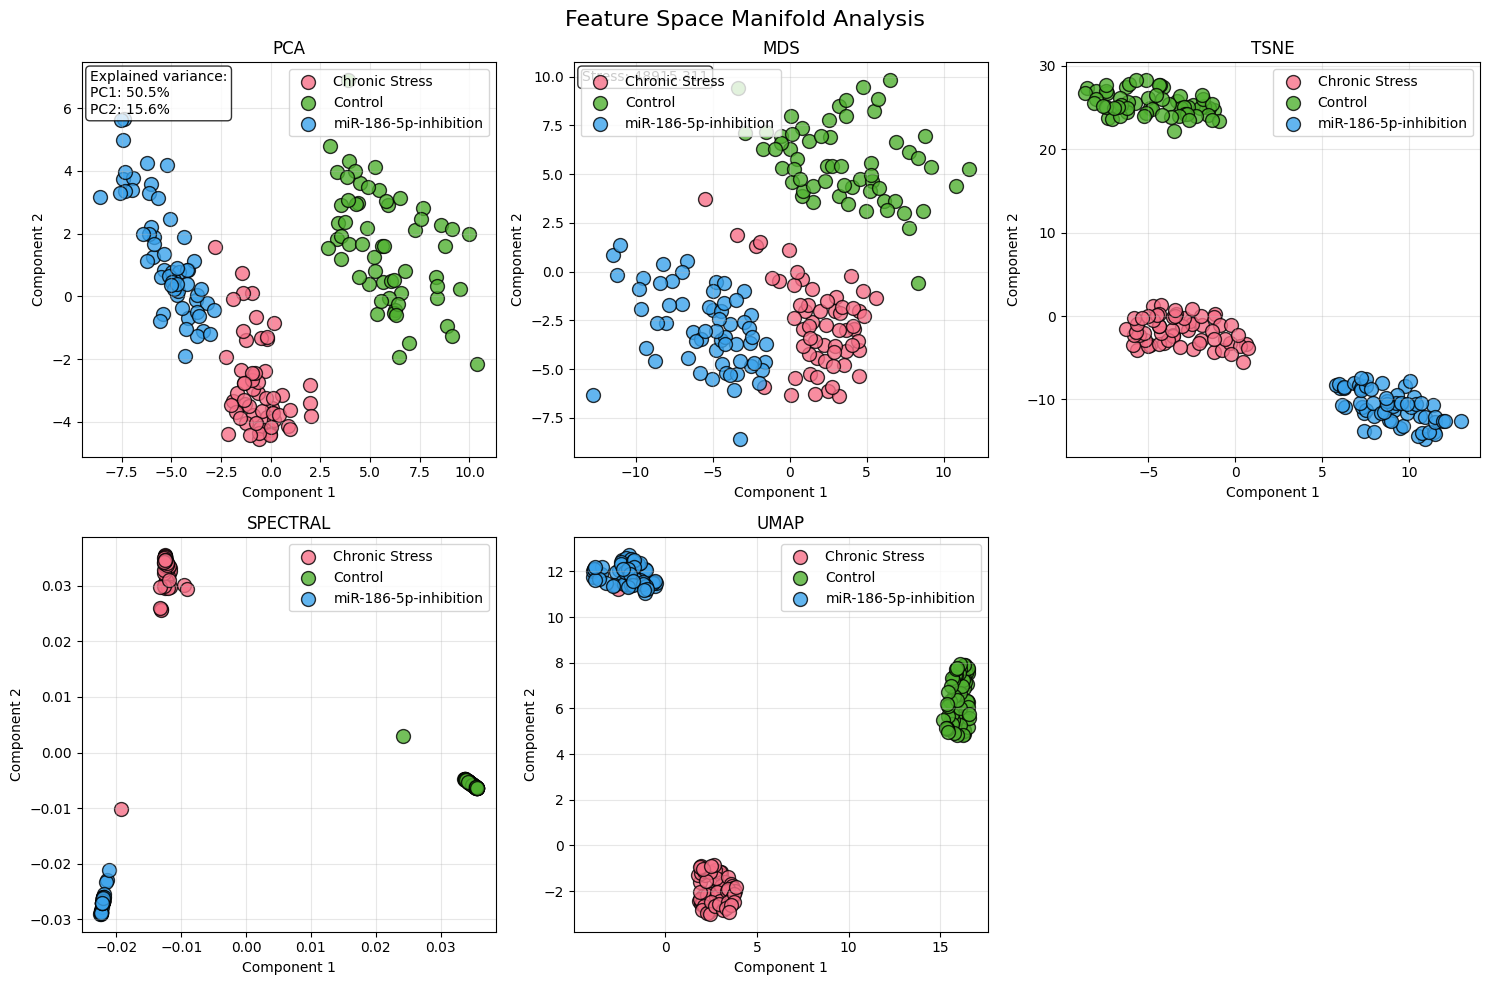

In [2]:
# Simple one-line analysis
results = analyze_feature_space(
    csv_path='./testing/results_temporal.csv',
    condition_column='condition',  # Replace with your actual condition column
    exclude_columns=['group_type', 'group_id', 'n_channels', 'recording_length'],  # Non-measurement columns to exclude
    methods=['PCA', 'MDS', 'TSNE', 'SPECTRAL', 'UMAP'],
    condition_names={'control': 'Control', 'chronic-stress': 'Chronic Stress', 'miR-186-5p-inhibition': 'miR-186-5p-inhibition'}  # Optional
)

Or, we can do a more fine-grained analysis, instead of using the wrapper above, so we have control over each step of the process. Let's demonstrate this with the single unit dataset.

/home/neuro/repos/mea-flow/src/mea_flow/analysis/feature_space.py:86: UserWarning: Found NaN values. Filling with column means.
  warnings.warn("Found NaN values. Filling with column means.")
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: [34 35 36 37 38]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Data shape: (192, 36) (192 samples, 41 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Applying PCA...
Applying MDS...
Applying TSNE...
Applying SPECTRAL...
Applying UMAP...


/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


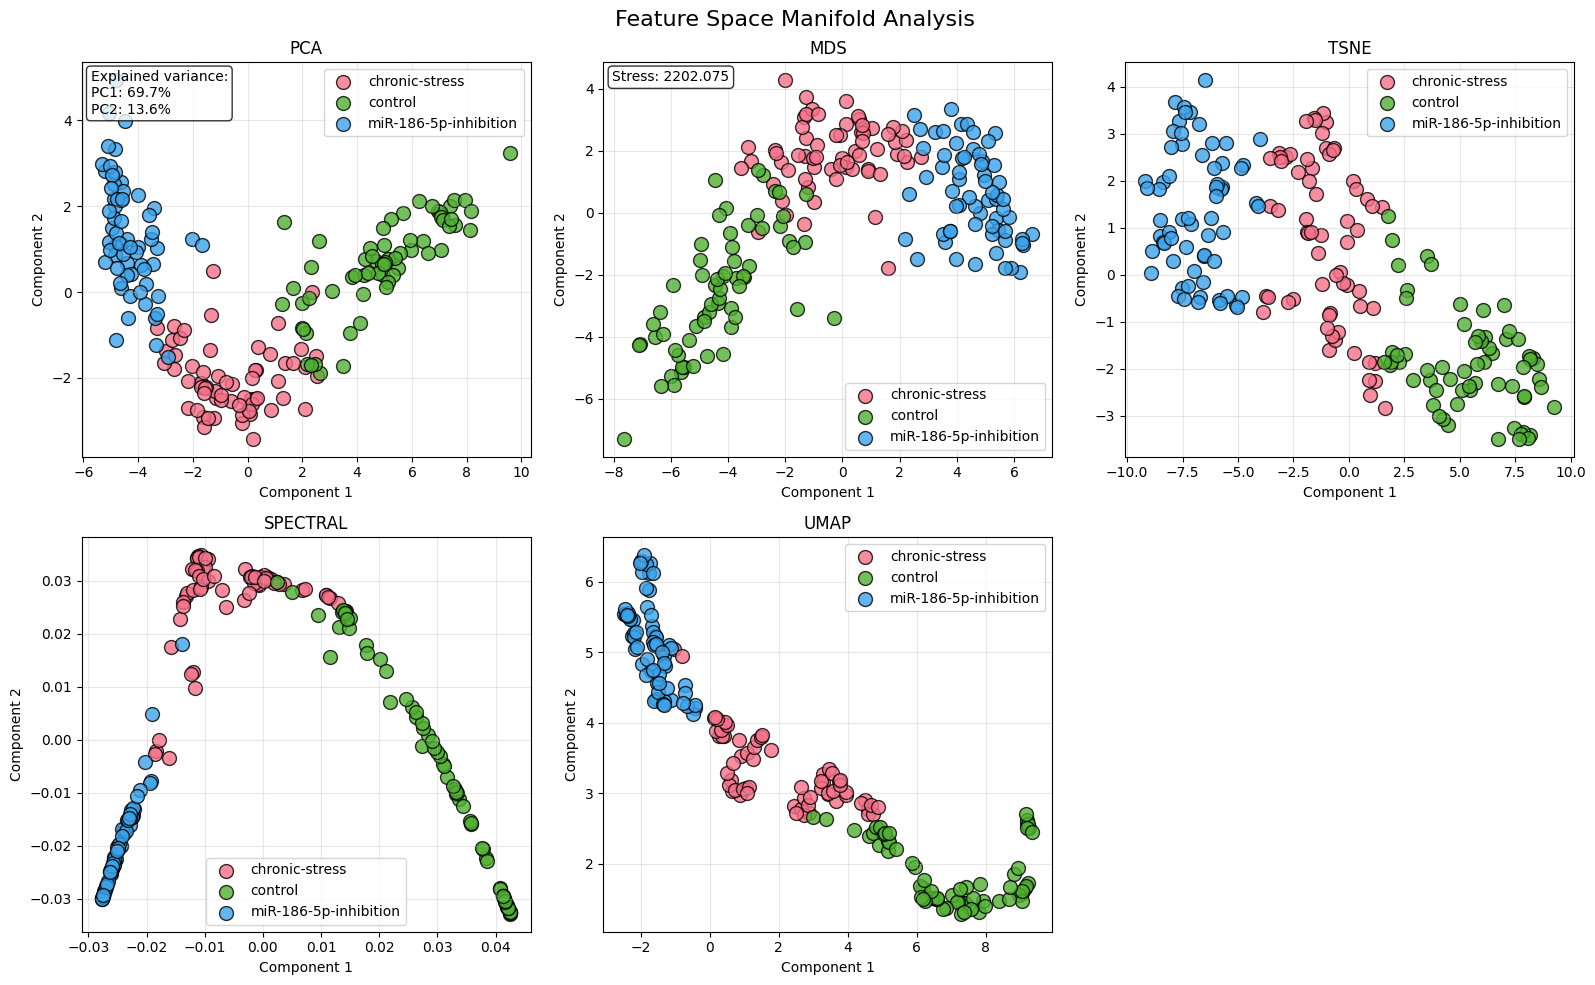

In [3]:
from mea_flow.analysis import (
    load_feature_data, 
    apply_multiple_embeddings, 
    plot_feature_embeddings,
)
import matplotlib.pyplot as plt

# Step 1: Load data
X, labels, feature_names = load_feature_data(
    csv_path='testing/results_channels.csv',
    condition_column='condition',
    exclude_columns=['group_type', 'group_id', 'n_channels', 'recording_length']
)

# Step 2: Apply embedding methods
embeddings, scaler = apply_multiple_embeddings(
    X, 
    methods=['PCA', 'MDS', 'TSNE', 'SPECTRAL', 'UMAP'],
    n_components=3
)

# Step 3: Create visualization
fig = plot_feature_embeddings(
    embeddings, 
    labels,
    # condition_names={0: 'Control', 1: 'Drug A', 2: 'Drug B'},
    figsize=(16, 10)
)
plt.show()

We can already see that different ways of analyzing and grouping the data give rise to very different structure. In any case, this is just the beginning of the analysis pipeline and serves as an indication of what we can expect from it. We can complement this initial, exploratory analysis with clustering algorithms to explore natural groupings in the data and to consolidate different features and measurements.

### 1.2. Cluster analysis
Whereas the previous methods, dimensionality reduction methods (PCA, MDS, t-SNE, UMAP, Spectral Embedding), are primarily unsupervised learning techniques focused on preserving data structure in lower dimensions, clustering algorithms attempt to group similar data points together and find commonalities and community structure in the datasets.  
A detailed explanation of all clustering methods implemented in MEA-Flow can be found in the [CLUSTERING_METHODS_DOCUMENTATION.md](CLUSTERING_METHODS_DOCUMENTATION.md). We will now demonstrate their application to the temporal dataset. We devised 3 ways to apply clustering algorithms to the data: a simple one-liner (`analyze_clustering`), a more complex step-by-step approach that allows us to select and parameterize methods more carefully, and an individualized application of each method, in case one needs to tweak parameters or combine different methods.

The clustering algorithms implemented are: 
- `K-means`: Fast, spherical clusters
- `GMM`: Probabilistic, flexible shapes
- `DBSCAN`: Density-based, automatic cluster detection
- `Hierarchical`: Tree structure, dendrograms

=== Feature Space Clustering Analysis ===
Data shape: (180, 47) (180 samples, 50 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Applying KMEANS...
Applying GMM...


/home/neuro/repos/mea-flow/src/mea_flow/analysis/feature_space.py:86: UserWarning: Found NaN values. Filling with column means.
  warnings.warn("Found NaN values. Filling with column means.")
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: [40 41 42]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Applying DBSCAN...
Applying HIERARCHICAL...

=== Clustering Analysis Summary ===
Number of features: 50
Number of samples: 180
True conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Target clusters: 3

=== Method Comparison ===
 n_clusters     inertia  n_iter  silhouette_score  calinski_harabasz_score  davies_bouldin_score       method  adjusted_rand_score  normalized_mutual_info           aic          bic  log_likelihood converged  n_noise_points  noise_ratio  n_leaves  n_connected_components
          3 3537.156237     4.0          0.328559               114.162804              1.180826       KMEANS             0.983286                0.974238           NaN          NaN             NaN       NaN             NaN          NaN       NaN                     NaN
          3         NaN     NaN          0.328559               114.162804              1.180826          GMM             0.983286                0.974238 -19445.944797 -8184.385984       73.610958      True        

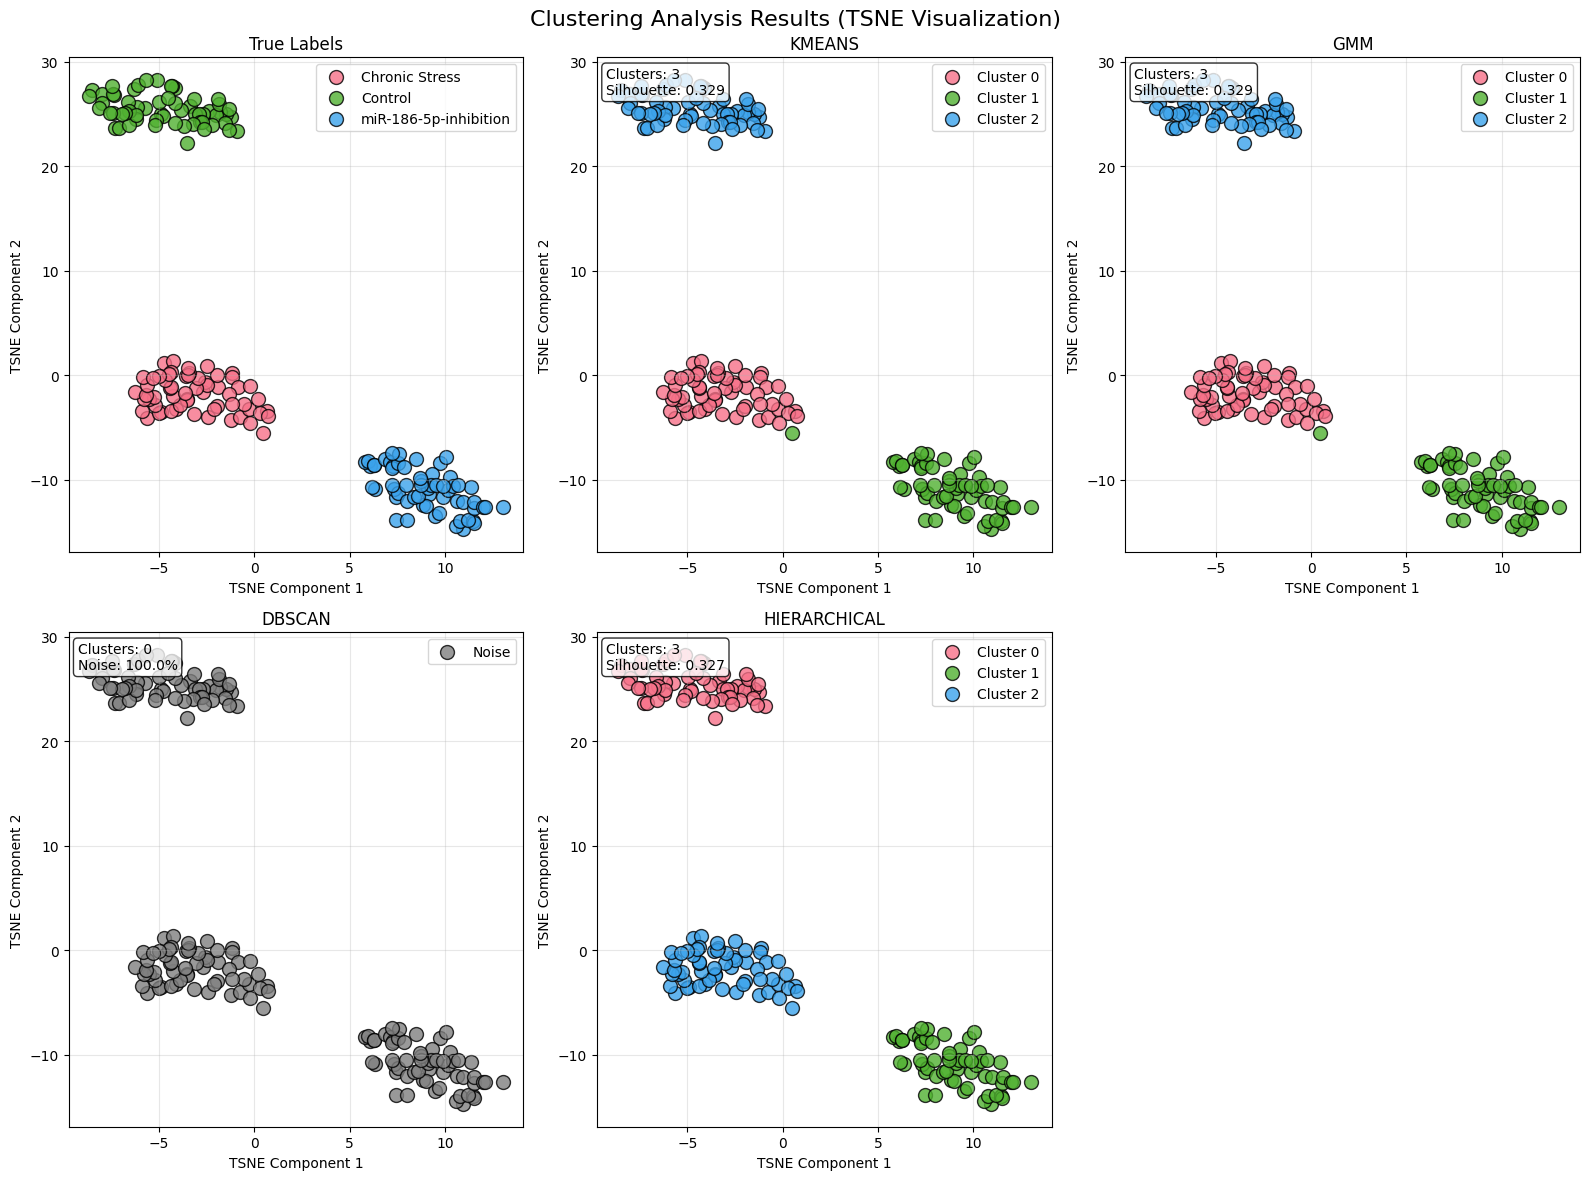

In [4]:
# Simple one-line clustering analysis
from mea_flow.analysis import analyze_clustering

results = analyze_clustering(
    csv_path='./testing/results_temporal.csv',
    condition_column='condition',
    exclude_columns=['group_type', 'group_id', 'n_channels', 'recording_length'],
    methods=['KMEANS', 'GMM', 'DBSCAN', 'HIERARCHICAL'],
    n_clusters=3,
    embedding_method='TSNE',  # For visualization
    condition_names={'control': 'Control', 'chronic-stress': 'Chronic Stress', 'miR-186-5p-inhibition': 'miR-186-5p-inhibition'}
)

/home/neuro/repos/mea-flow/src/mea_flow/analysis/feature_space.py:86: UserWarning: Found NaN values. Filling with column means.
  warnings.warn("Found NaN values. Filling with column means.")
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: [34 35 36 37 38]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Data shape: (192, 36) (192 samples, 41 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Applying KMEANS...
Applying GMM...
Applying DBSCAN...
Applying HIERARCHICAL...


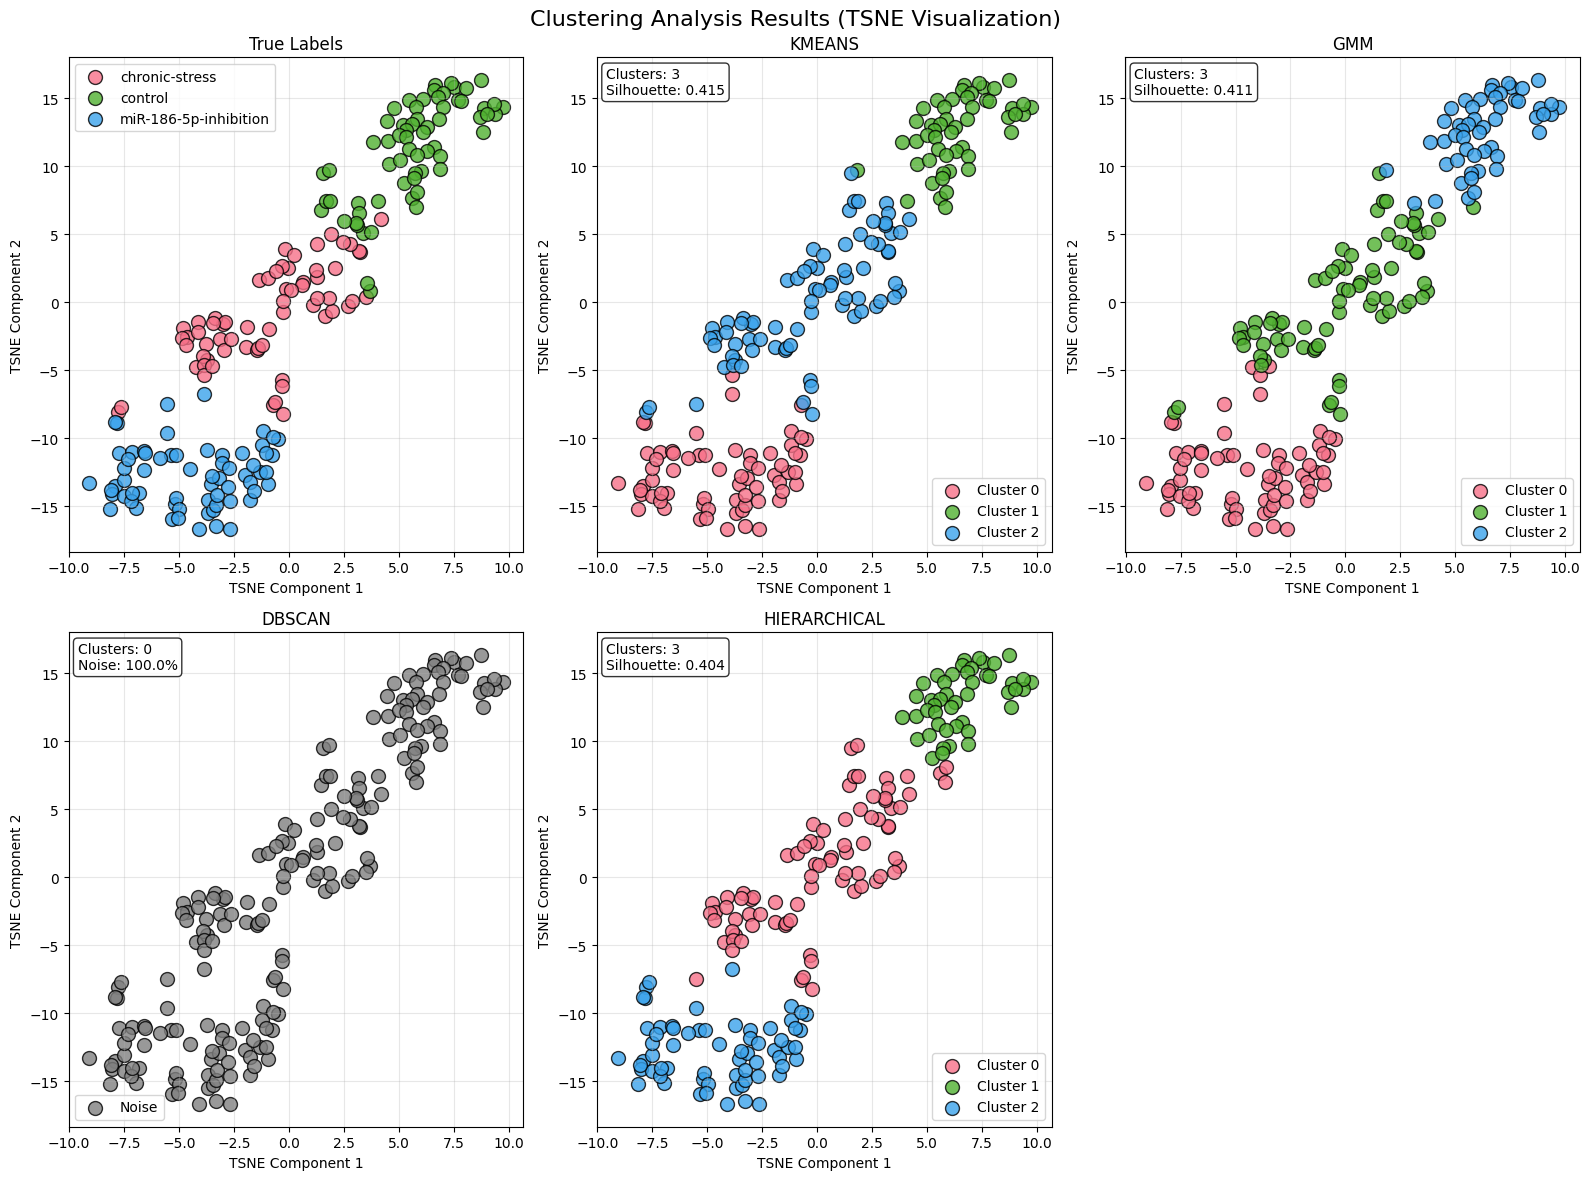

,n_clusters,inertia,n_iter,silhouette_score,calinski_harabasz_score,davies_bouldin_score,adjusted_rand_score,normalized_mutual_info,aic,bic,log_likelihood,converged,n_noise_points,noise_ratio,n_leaves,n_connected_components
method,,,,,,,,,,,,,,,,
KMEANS,3,1336.955688,4.0,0.415428,231.207130,0.912363,0.772417,0.773016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GMM,3,NaN,NaN,0.410935,229.226790,0.918527,0.775435,0.783017,-49214.831857,-42348.031613,139.142791,True,NaN,NaN,NaN,NaN
DBSCAN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,1.0,NaN,NaN
HIERARCHICAL,3,NaN,NaN,0.403648,219.720304,0.918743,0.715371,0.738475,NaN,NaN,NaN,NaN,NaN,NaN,192.0,1.0


In [5]:
from mea_flow.analysis import (
    load_feature_data, 
    apply_multiple_clustering, 
    plot_clustering_results,
    compare_clustering_methods
)
import matplotlib.pyplot as plt

# Step 1: Load data
X, labels, feature_names = load_feature_data(
    csv_path='testing/results_channels.csv',
    condition_column='condition',
    exclude_columns=['group_type', 'group_id', 'n_channels', 'recording_length']
)

# Step 2: Apply clustering methods
clustering_results = apply_multiple_clustering(
    X, 
    methods=['KMEANS', 'GMM', 'DBSCAN', 'HIERARCHICAL'],
    n_clusters=3,
    # Method-specific parameters
    dbscan_eps=0.5,
    dbscan_min_samples=5,
    gmm_covariance_type='full',
    hierarchical_linkage='ward'
)

# Step 3: Create visualization
fig = plot_clustering_results(
    clustering_results, 
    X, 
    labels,
    embedding_method='TSNE',  # Can use PCA, TSNE, UMAP, etc.
    figsize=(16, 12)
)
plt.show()

# Step 4: Compare methods quantitatively
comparison_df = compare_clustering_methods(clustering_results, true_labels=labels)
comparison_df.set_index('method', inplace=True)

comparison_df


/home/neuro/repos/mea-flow/src/mea_flow/analysis/feature_space.py:86: UserWarning: Found NaN values. Filling with column means.
  warnings.warn("Found NaN values. Filling with column means.")
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: [34 35 36 37 38]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Data shape: (192, 36) (192 samples, 41 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
BIC: -42348.03
Found 0 clusters
Noise ratio: 100.0%


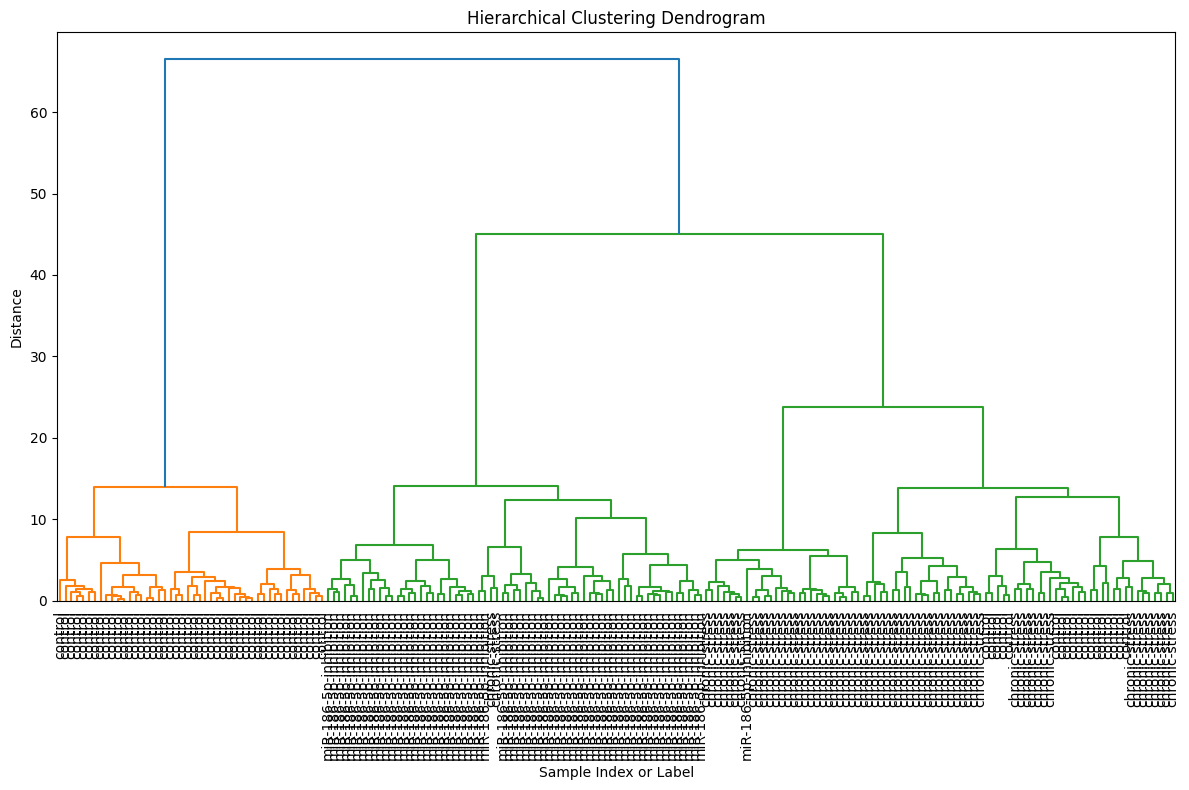

In [6]:
# Apply manually
from mea_flow.analysis import (
    apply_kmeans_clustering,
    apply_gmm_clustering, 
    apply_dbscan_clustering,
    apply_hierarchical_clustering,
    plot_dendrogram
)
# Step 1: Load data
X, labels, feature_names = load_feature_data(
    csv_path='testing/results_channels.csv',
    condition_column='condition',
    exclude_columns=['group_type', 'group_id', 'n_channels', 'recording_length']
)

# K-means clustering
kmeans_result = apply_kmeans_clustering(X, n_clusters=3, random_state=42)

# GMM with model selection
gmm_result = apply_gmm_clustering(X, n_components=3, covariance_type='full')
print(f"BIC: {gmm_result['metrics']['bic']:.2f}")

# DBSCAN for automatic cluster detection
dbscan_result = apply_dbscan_clustering(X, eps=0.5, min_samples=5)
print(f"Found {dbscan_result['metrics']['n_clusters']} clusters")
print(f"Noise ratio: {dbscan_result['metrics']['noise_ratio']:.1%}")

# Hierarchical clustering with dendrogram
hierarchical_result = apply_hierarchical_clustering(X, n_clusters=3, linkage_method='ward')
dendrogram_fig = plot_dendrogram(hierarchical_result, labels=labels)
plt.show()

---

## 2. Feature importance 
The goal of these analysis is to determine which, among the many measurements/features allows a clearer differentiation between experimental conditions, thus indicating the most prevalent effects of the experimental manipulation. Understanding the significance of the different metrics/features and their impact in the data structure is very important not only in biological terms (to identify causality: experimental modification x yields effect y) but also to identify redundancies and irrelevant measurements that do not contribute meaningful information. 
An appropriate feature analysis requires a comprehensive pipeline to move from raw metric space to informative feature spaces that identify the conditions of interest and their main effects. This pipeline involves (see [FEATURE_ANALYSIS_METHODS_REFERENCE.md](FEATURE_ANALYSIS_METHODS_REFERENCE.md) for a complete description of all methods involved):

1. Preprocessing and redundancy detection
2. Core feature selection and ranking
3. Validation and consensus
4. Feature categorization and final ranking



In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from mea_flow.analysis.discriminant import (
    FeatureAnalysisConfig, FeatureSelectionMethod,
    AnalysisPhase,
    comprehensive_feature_analysis
)
from mea_flow.visualization import (
    plot_feature_importance,
    plot_consensus_ranking,
    plot_redundancy_analysis,
    plot_method_importance_comparison,
    plot_analysis_summary,
    plot_feature_stability,
    plot_method_performance
)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


data = pd.read_csv('./testing/results_temporal.csv', index_col=0)
data

print("=== MEA Feature Analysis Pipeline Demo ===")
print(f"Dataset: {len(data)} samples, {len(data.columns)-1} features, 3 conditions")
print(f"Conditions: {data['condition'].value_counts().to_dict()}")

=== MEA Feature Analysis Pipeline Demo ===
Dataset: 180 samples, 53 features, 3 conditions
Conditions: {'control': 60, 'chronic-stress': 60, 'miR-186-5p-inhibition': 60}


### 2.1. Comprehensive Feature Analysis with all phases and metrics in the pipeline



In [8]:
# Configure comprehensive analysis
config = FeatureAnalysisConfig(
    target_column='condition',
    phases=[
        AnalysisPhase.REDUNDANCY_DETECTION,
        AnalysisPhase.CORE_SELECTION, 
        AnalysisPhase.CONSENSUS
    ],
    methods=[
        # Filter methods
        FeatureSelectionMethod.MUTUAL_INFORMATION,
        FeatureSelectionMethod.ANOVA_F_TEST,
        # Embedded methods
        FeatureSelectionMethod.RANDOM_FOREST,
        FeatureSelectionMethod.LASSO,
        FeatureSelectionMethod.LDA,
        FeatureSelectionMethod.SVM_L1,
        FeatureSelectionMethod.XGBOOST,
        FeatureSelectionMethod.RIDGE,
        FeatureSelectionMethod.ELASTIC_NET,
        # Specialized methods
        FeatureSelectionMethod.MRMR,
        FeatureSelectionMethod.RELIEF_F
    ],
    exclude_columns=['group_type', 'group_id', 'n_channels', 'recording_length'],
    
    # Redundancy thresholds
    vif_threshold=10.0,
    correlation_threshold=0.9,
    variance_threshold=0.01,
    
    # Analysis parameters
    scale_features=True,
    handle_missing='median',
    cv_folds=5,
    cv_scoring='accuracy', # or 'f1_macro' for imbalanced data
    alpha=0.05, # statistical significance threshold
    multiple_testing_correction='fdr_bh', # "bonferroni", "fdr_bh", "none"
    random_state=42,
    n_jobs=-1, # parallel processing (-1 to use all cores)

    # Bootstrap and stability settings
    n_bootstrap=100, # number of samples
    stability_threshold=0.8, # feature stability threshold
    
    # Method-specific parameters
    rf_n_estimators=100,
    lasso_alpha=0.1,
    ridge_alpha=1.0,
    svm_C=1.0,
    xgb_n_estimators=100,
    mrmr_k=10, 
    relief_n_neighbors=10,
    relief_n_iterations=100,
    elastic_net_alpha=0.01,
    elastic_net_l1_ratio=0.5
)

# Run comprehensive analysis
print("Running comprehensive feature analysis...")
print(f"Methods: {[method.value for method in config.methods]}")
print(f"Phases: {[phase.value for phase in config.phases]}")
results = comprehensive_feature_analysis(data, config)

print(f"\nAnalysis completed in {results.execution_time:.2f} seconds")
print(f"Critical features found: {len(results.critical_features)}")
print(f"Redundant features found: {len(results.redundant_features)}")
print(f"Warnings: {len(results.warnings)}")

Running comprehensive feature analysis...
Methods: ['mutual_information', 'anova_f_test', 'random_forest', 'lasso_regression', 'linear_discriminant_analysis', 'svm_l1_penalty', 'xgboost', 'ridge_regression', 'elastic_net', 'minimum_redundancy_maximum_relevance', 'relief_f_algorithm']
Phases: ['redundancy_detection', 'core_selection', 'consensus']


/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Analysis completed in 1.27 seconds
Critical features found: 7
Redundant features found: 42
Warnings: 0


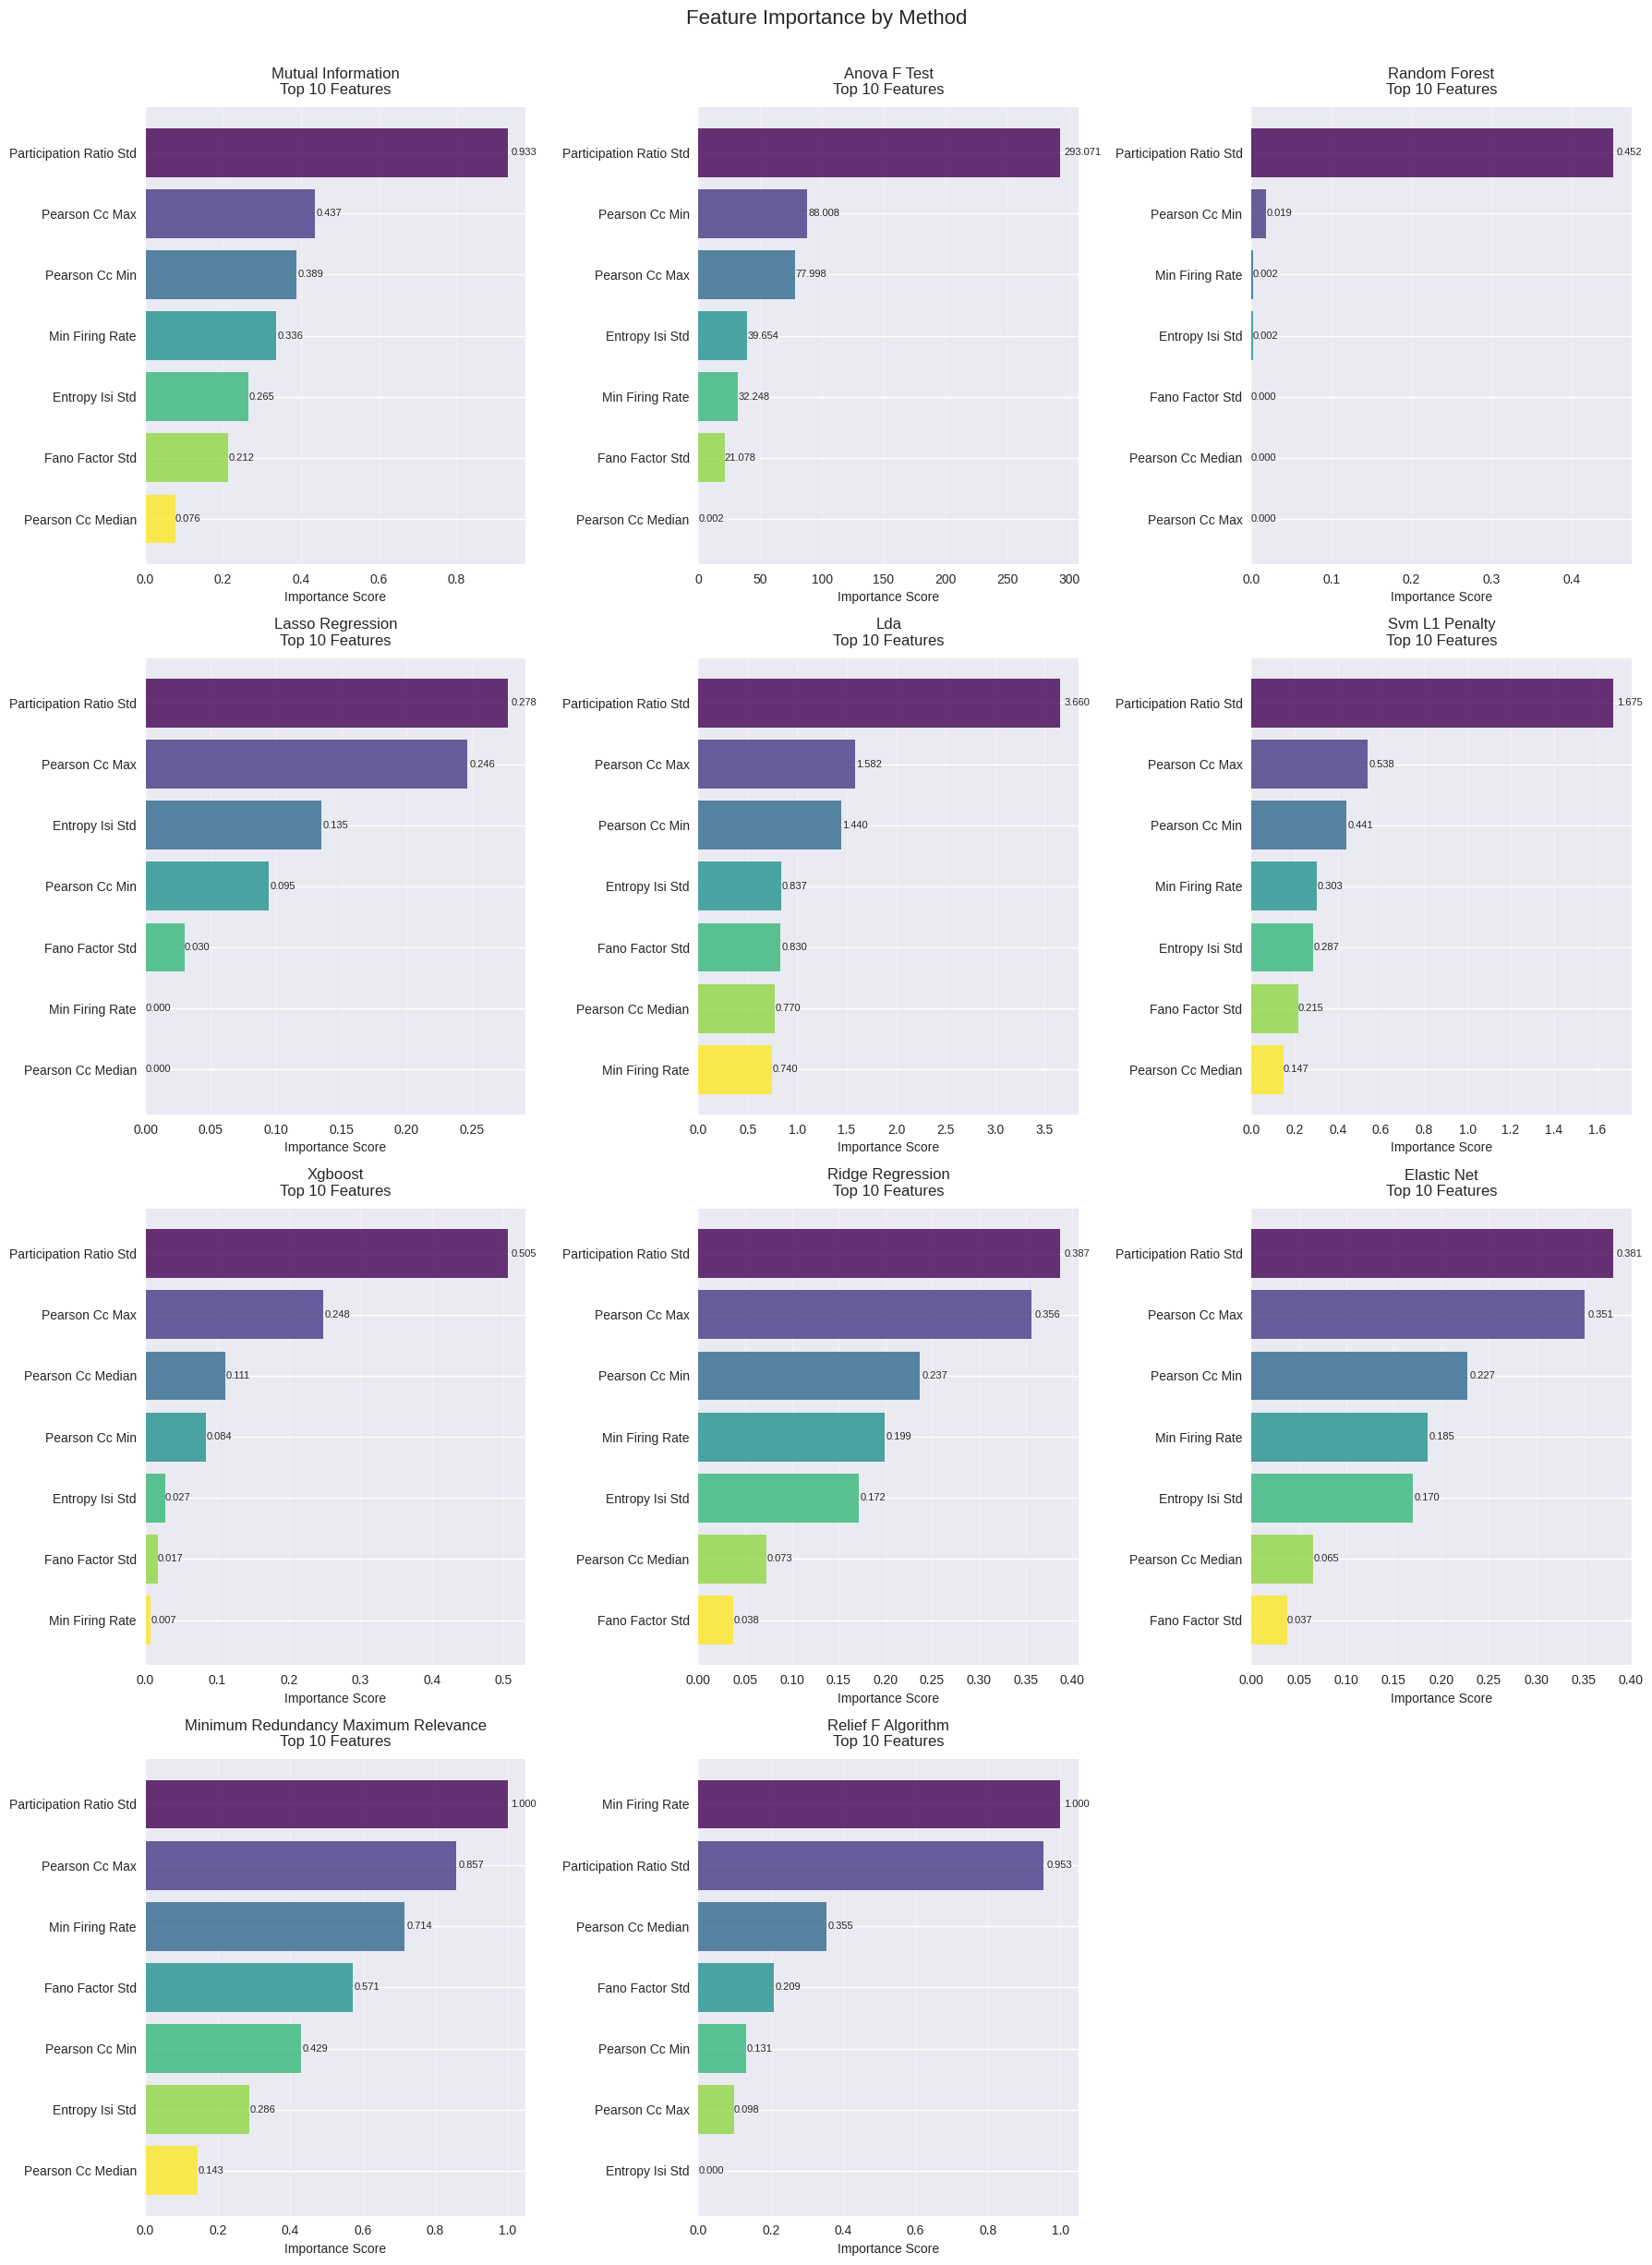

In [9]:
# Plot feature importance for each method
n_methods = len(results.importance_results)
n_cols = 3
n_rows = (n_methods + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, (method_name, importance_result) in enumerate(results.importance_results.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # Get top 10 features
        top_features = importance_result.scores.nlargest(10, 'importance')
        
        # Create horizontal bar plot with MEA-Flow styling
        y_pos = np.arange(len(top_features))
        colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
        
        bars = ax.barh(y_pos, top_features['importance'], color=colors, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([name.replace('_', ' ').title() for name in top_features['feature']], 
                          fontsize=10)
        ax.invert_yaxis()
        ax.set_xlabel('Importance Score', fontsize=10)
        ax.set_title(f'{method_name.replace("_", " ").title()}\nTop 10 Features', 
                    fontsize=12, pad=10)
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels on bars
        for i, (bar, score) in enumerate(zip(bars, top_features['importance'])):
            width = bar.get_width()
            ax.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                   f'{score:.3f}', ha='left', va='center', fontsize=8)

# Remove empty subplots
for idx in range(n_methods, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('Feature Importance by Method', fontsize=16, y=1.02)
plt.show()

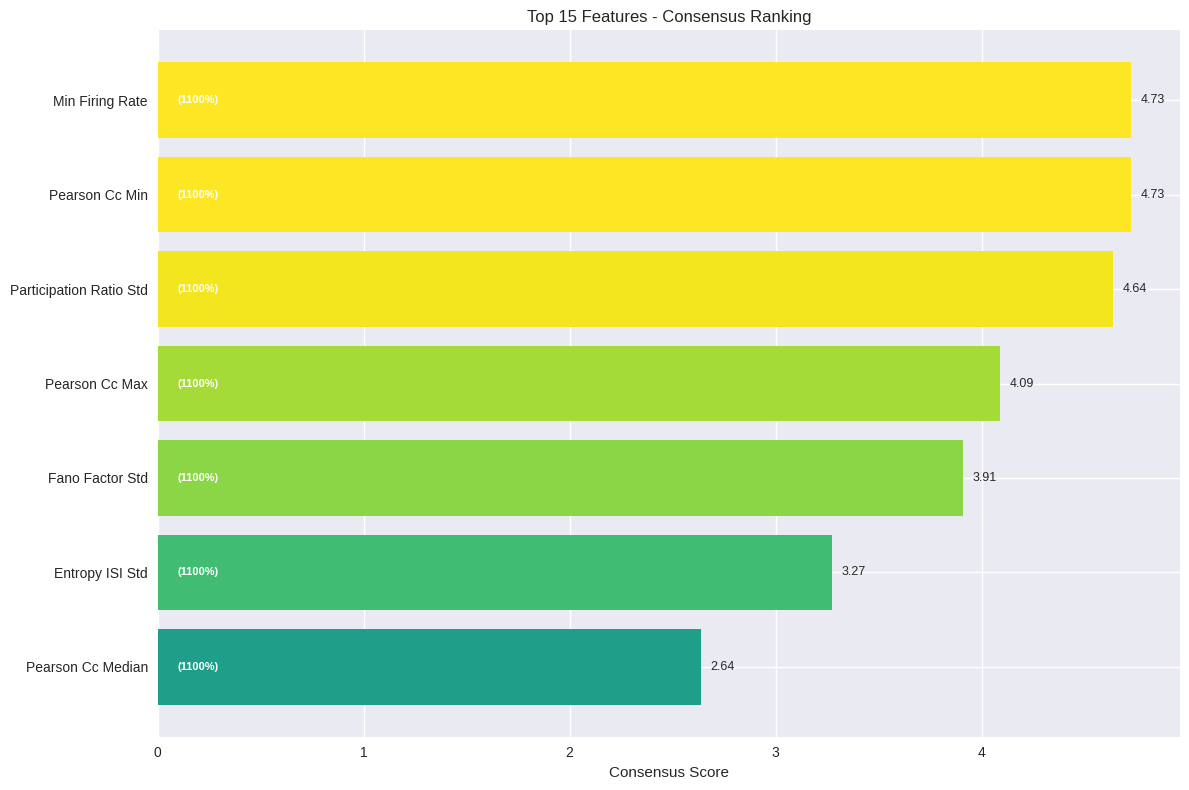


Top 10 Consensus Features:
 1. min_firing_rate           | Score: 4.727 | Agreement: 11.00
 2. pearson_cc_min            | Score: 4.727 | Agreement: 11.00
 3. participation_ratio_std   | Score: 4.636 | Agreement: 11.00
 4. pearson_cc_max            | Score: 4.091 | Agreement: 11.00
 5. fano_factor_std           | Score: 3.909 | Agreement: 11.00
 6. entropy_isi_std           | Score: 3.273 | Agreement: 11.00
 7. pearson_cc_median         | Score: 2.636 | Agreement: 11.00


In [10]:
# Plot consensus ranking
if results.consensus_result is not None:
    fig = plot_consensus_ranking(results, top_n=15, figsize=(12, 8))
    plt.show()
    
    # Display top consensus features
    print("\nTop 10 Consensus Features:")
    print("=" * 50)
    top_consensus = results.consensus_result.consensus_ranking.head(10)
    for idx, row in top_consensus.iterrows():
        print(f"{idx+1:2d}. {row['feature']:<25} | Score: {row['consensus_score']:.3f} | Agreement: {row['method_agreement']:.2f}")
else:
    print("No consensus ranking available")

#### 2.1.1. Redundancy Detection Results

In [11]:
# Examine redundancy detection results
print("\n=== Redundancy Detection Results ===")

if 'vif' in results.redundancy_results:
    vif_result = results.redundancy_results['vif']
    print(f"VIF Analysis: {len(vif_result.redundant_features)} redundant features")
    print("Top 5 highest VIF scores:")
    print(vif_result.scores.head())

if 'correlation' in results.redundancy_results:
    corr_result = results.redundancy_results['correlation']
    print(f"\nCorrelation Analysis: {len(corr_result.redundant_features)} redundant features")
    if len(corr_result.scores) > 0:
        print("Top 5 highest correlations:")
        print(corr_result.scores.head())

print(f"\nTotal redundant features identified: {len(results.redundant_features)}")
print(f"Redundant features: {results.redundant_features[:10]}...")  # Show first 10


=== Redundancy Detection Results ===
VIF Analysis: 42 redundant features
Top 5 highest VIF scores:
              feature  vif_score  redundant
0    mean_firing_rate        inf       True
1     std_firing_rate        inf       True
2  median_firing_rate  78.874025       True
3     max_firing_rate  81.766953       True
4     min_firing_rate   5.630670      False

Correlation Analysis: 24 redundant features
Top 5 highest correlations:
          feature_1           feature_2  correlation
0  mean_firing_rate     std_firing_rate     0.906555
1  mean_firing_rate  median_firing_rate     0.979524
2  mean_firing_rate     max_firing_rate     0.957631
3  mean_firing_rate   total_spike_count     0.998911
4  mean_firing_rate    mean_spike_count     1.000000

Total redundant features identified: 42
Redundant features: ['population_cv', 'pop_vector_length_std', 'window_start', 'cv_isi_mean', 'van_rossum_distance_std', 'std_firing_rate', 'synchrony_index', 'global_activity_cv', 'mean_spike_count', 'is

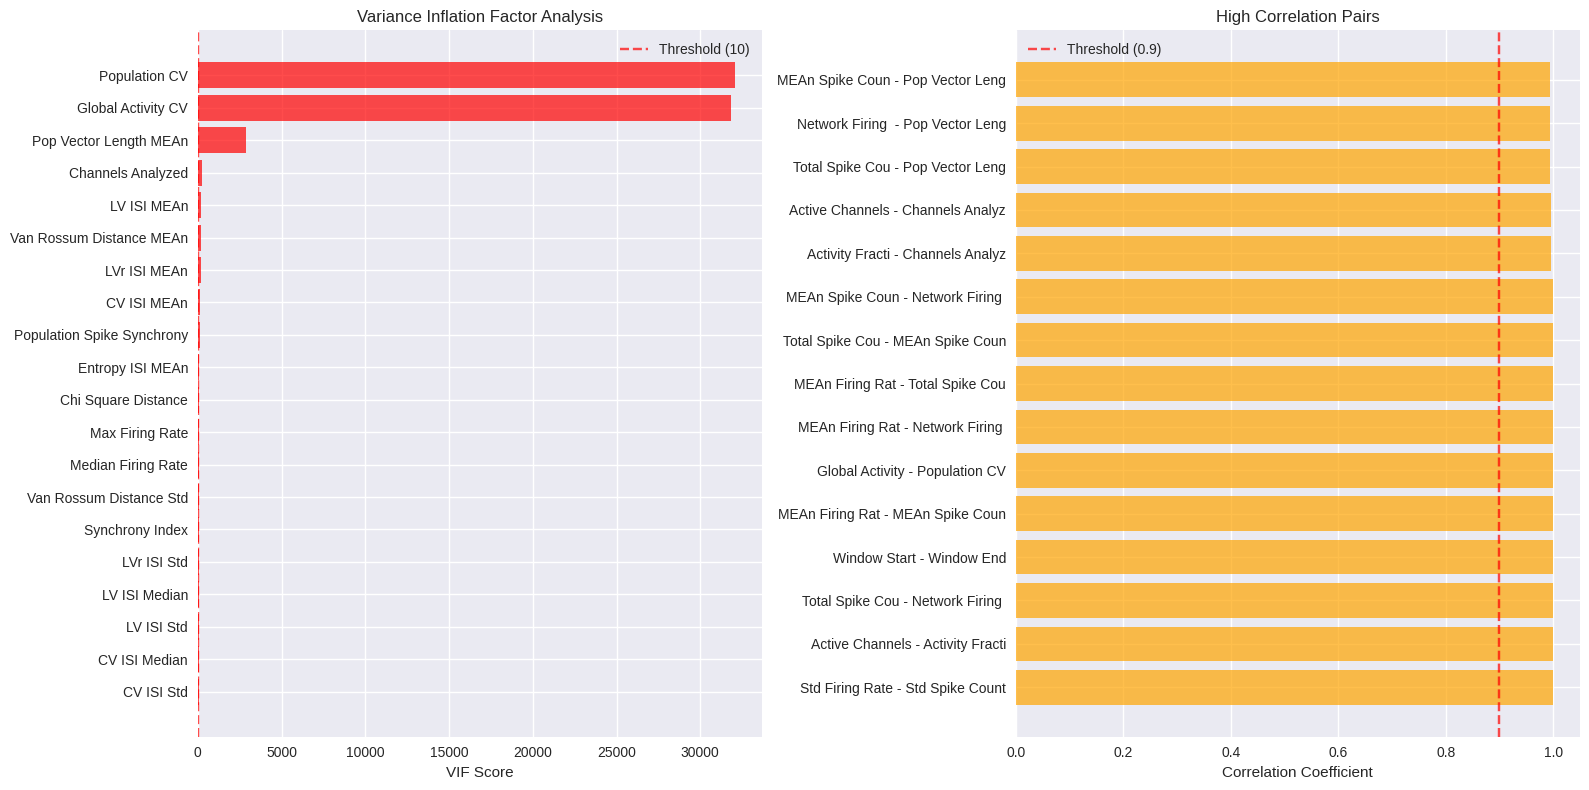


Redundancy Analysis Summary:
VIF: 42 redundant features
  Features: mean_firing_rate, std_firing_rate, median_firing_rate, max_firing_rate, total_spike_count...
CORRELATION: 24 redundant features
  Features: population_cv, van_rossum_distance_std, std_firing_rate, synchrony_index, mean_spike_count...


In [12]:
# Plot redundancy analysis
if results.redundancy_results:
    fig = plot_redundancy_analysis(results, figsize=(16, 8))
    plt.show()
    
    # Display redundancy summary
    print("\nRedundancy Analysis Summary:")
    print("=" * 40)
    for method_name, redundancy_result in results.redundancy_results.items():
        print(f"{method_name.upper()}: {len(redundancy_result.redundant_features)} redundant features")
        if redundancy_result.redundant_features:
            print(f"  Features: {', '.join(redundancy_result.redundant_features[:5])}{'...' if len(redundancy_result.redundant_features) > 5 else ''}")
else:
    print("No redundancy analysis results available")

#### 2.1.2. Feature Importance Results

In [13]:
# Examine feature importance results
print("\n=== Feature Importance Results ===")

for method_name, importance_result in results.importance_results.items():
    print(f"\n{method_name.upper()} Results:")
    print(f"Execution time: {importance_result.execution_time:.3f}s")
    
    # Show top 10 features
    top_features = importance_result.scores.head(10)
    print("Top 10 most important features:")
    for _, row in top_features.iterrows():
        significance = " *" if not pd.isna(row['p_value']) and row['p_value'] < 0.05 else ""
        print(f"  {row['feature']}: {row['importance']:.4f} (rank {row['rank']}){significance}")
    
    # Show selection summary
    n_selected = importance_result.scores['selected'].sum()
    print(f"Selected features: {n_selected}/{len(importance_result.scores)}")


=== Feature Importance Results ===

MUTUAL_INFORMATION Results:
Execution time: 0.028s
Top 10 most important features:
  participation_ratio_std: 0.9331 (rank 1)
  pearson_cc_max: 0.4369 (rank 2)
  pearson_cc_min: 0.3888 (rank 3)
  min_firing_rate: 0.3365 (rank 4)
  entropy_isi_std: 0.2646 (rank 5)
  fano_factor_std: 0.2122 (rank 6)
  pearson_cc_median: 0.0761 (rank 7)
Selected features: 3/7

ANOVA_F_TEST Results:
Execution time: 0.003s
Top 10 most important features:
  participation_ratio_std: 293.0706 (rank 1) *
  pearson_cc_min: 88.0082 (rank 2) *
  pearson_cc_max: 77.9982 (rank 3) *
  entropy_isi_std: 39.6543 (rank 4) *
  min_firing_rate: 32.2484 (rank 5) *
  fano_factor_std: 21.0779 (rank 6) *
  pearson_cc_median: 0.0023 (rank 7)
Selected features: 6/7

RANDOM_FOREST Results:
Execution time: 0.373s
Top 10 most important features:
  participation_ratio_std: 0.4522 (rank 1)
  pearson_cc_min: 0.0189 (rank 2)
  min_firing_rate: 0.0022 (rank 3)
  entropy_isi_std: 0.0022 (rank 4)
  fan

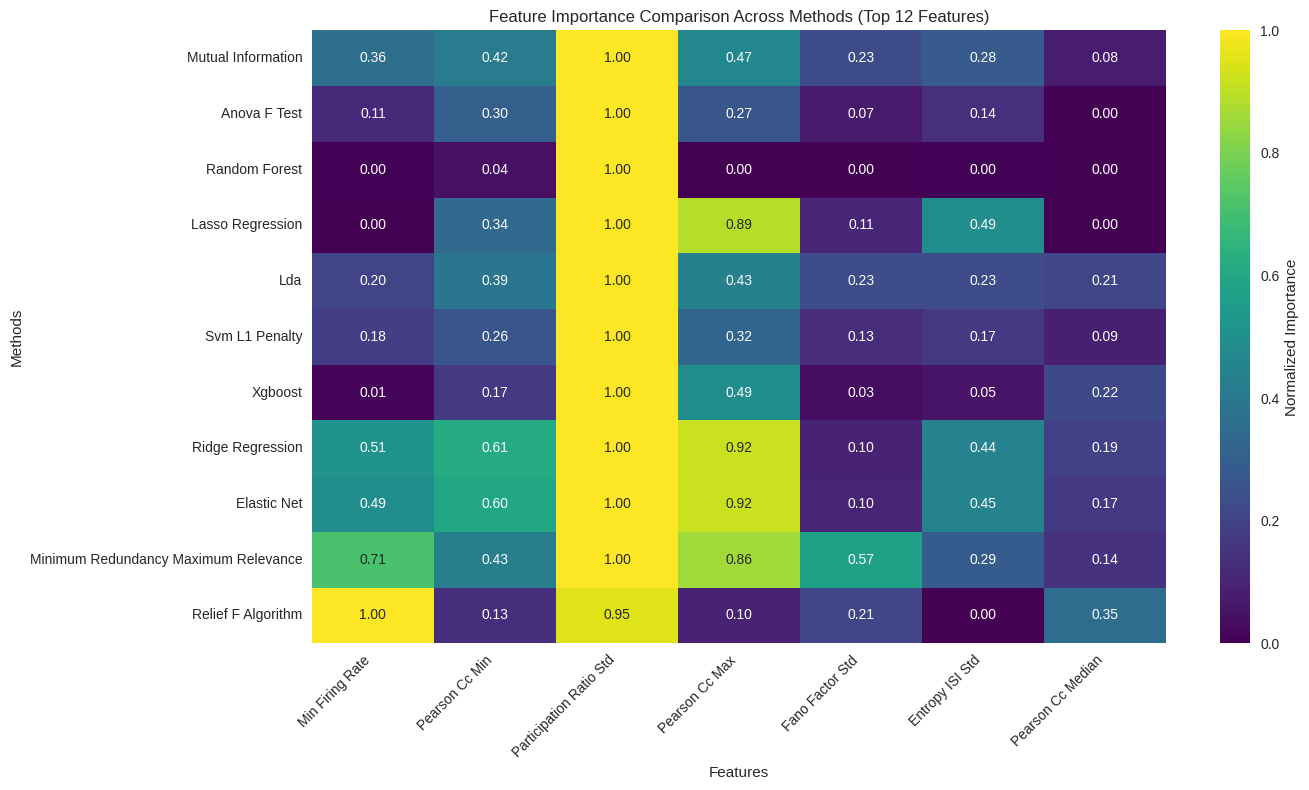

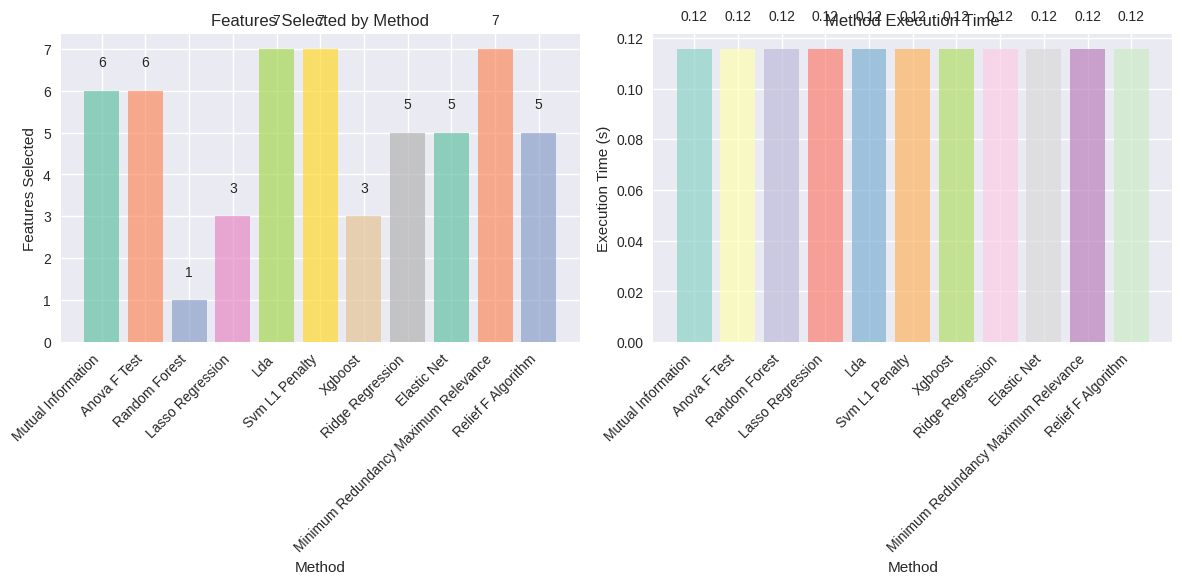

In [14]:
# Plot method importance comparison
if results.importance_results:
    fig = plot_method_importance_comparison(results, top_n=12, figsize=(14, 8))
    plt.show()
    
    # Method performance comparison
    fig = plot_method_performance(results, figsize=(12, 6))
    plt.show()
else:
    print("No importance results available for comparison")

/home/neuro/repos/mea-flow/src/mea_flow/visualization/discriminant.py:537: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(top_features['method_agreement'], top_features['consensus_score'], 1)


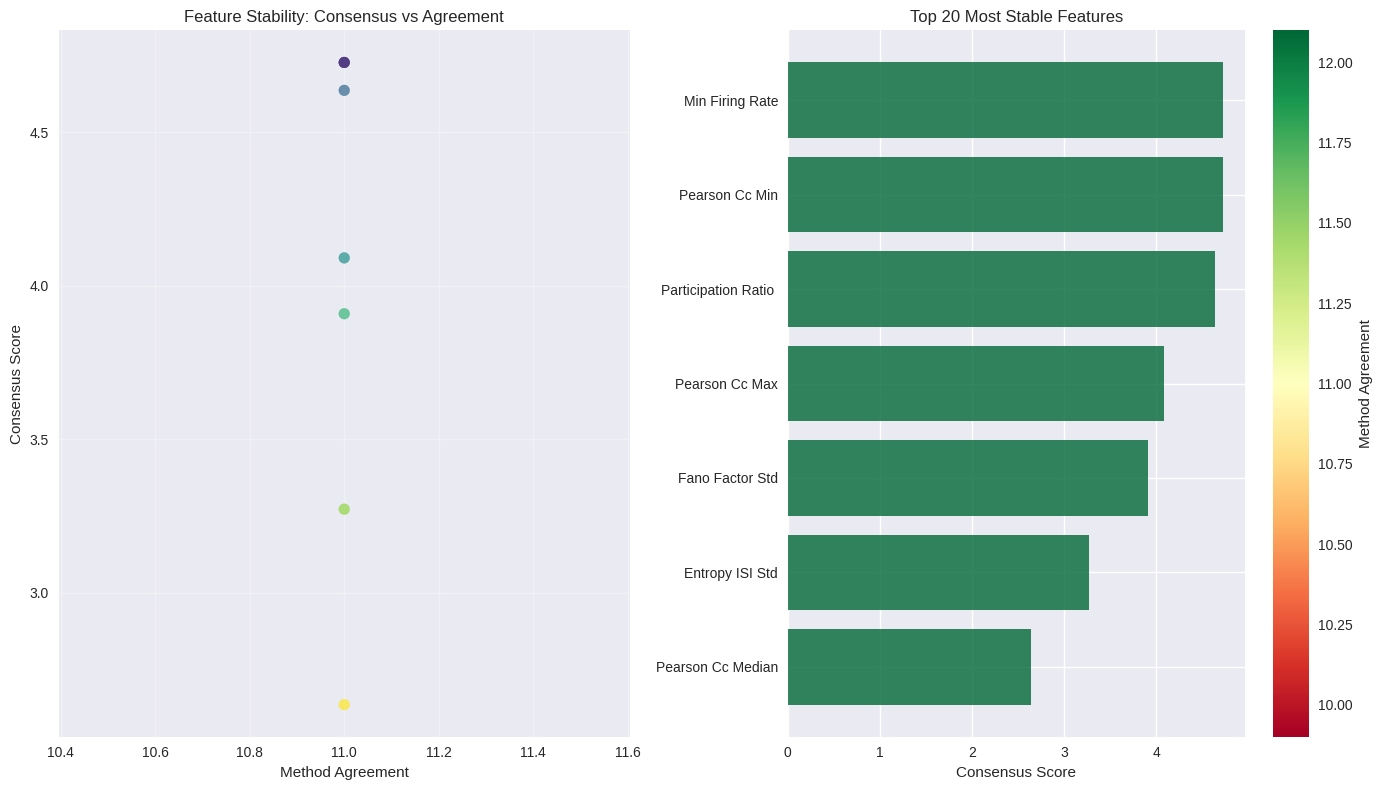


Feature Stability Statistics:
Mean method agreement: 11.000
Std method agreement:  0.000
Most stable feature:   min_firing_rate
Highest consensus:     min_firing_rate


In [15]:
# Plot feature stability
if results.consensus_result is not None:
    fig = plot_feature_stability(results, top_n=20, figsize=(14, 8))
    plt.show()
    
    # Stability statistics
    consensus_df = results.consensus_result.consensus_ranking
    print("\nFeature Stability Statistics:")
    print("=" * 35)
    print(f"Mean method agreement: {consensus_df['method_agreement'].mean():.3f}")
    print(f"Std method agreement:  {consensus_df['method_agreement'].std():.3f}")
    print(f"Most stable feature:   {consensus_df.loc[consensus_df['method_agreement'].idxmax(), 'feature']}")
    print(f"Highest consensus:     {consensus_df.loc[consensus_df['consensus_score'].idxmax(), 'feature']}")
else:
    print("No consensus results available for stability analysis")

#### 2.1.3. Consensus Ranking and Final Results

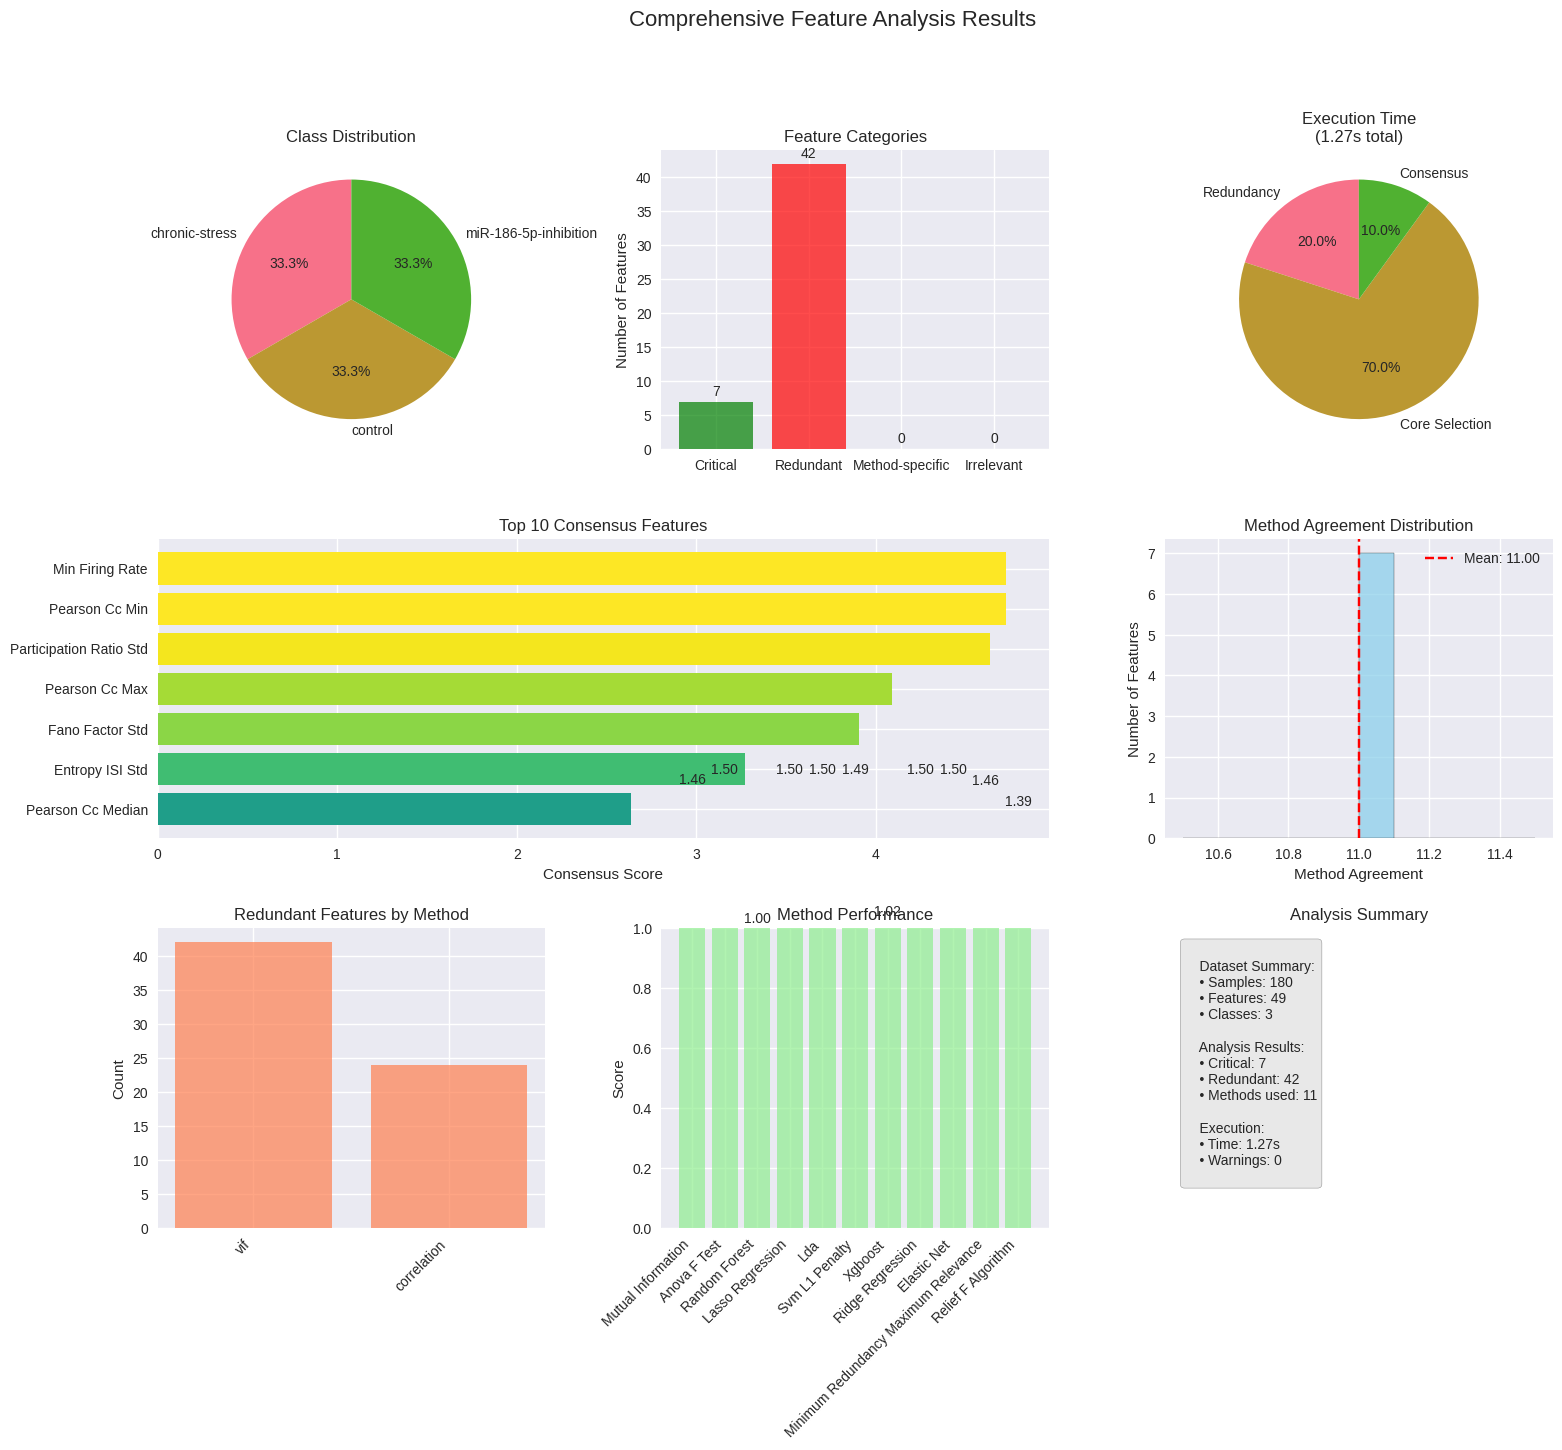


COMPREHENSIVE FEATURE ANALYSIS SUMMARY

Dataset Information:
  Samples: 180
  Features: 49
  Classes: 3 ['chronic-stress', 'control', 'miR-186-5p-inhibition']

Feature Categories:
  Critical features: 7
  Redundant features: 42
  Method-specific: 0
  Irrelevant features: 0

Execution Summary:
  Total time: 1.27 seconds
  Methods used: 11
  Warnings: 0

Top Critical Features:
  1. min_firing_rate
  2. pearson_cc_min
  3. participation_ratio_std
  4. pearson_cc_max
  5. fano_factor_std


In [16]:
# Plot comprehensive analysis summary
fig = plot_analysis_summary(results, figsize=(18, 14))
plt.show()

# Print detailed summary
print("\n" + "=" * 60)
print("COMPREHENSIVE FEATURE ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nDataset Information:")
print(f"  Samples: {results.n_samples:,}")
print(f"  Features: {results.n_features:,}")
print(f"  Classes: {results.n_classes} {list(results.class_distribution.keys())}")

print(f"\nFeature Categories:")
print(f"  Critical features: {len(results.critical_features)}")
print(f"  Redundant features: {len(results.redundant_features)}")
print(f"  Method-specific: {sum(len(feats) for feats in results.method_specific_features.values())}")
print(f"  Irrelevant features: {len(results.irrelevant_features)}")

print(f"\nExecution Summary:")
print(f"  Total time: {results.execution_time:.2f} seconds")
print(f"  Methods used: {len(results.importance_results)}")
print(f"  Warnings: {len(results.warnings)}")

if results.critical_features:
    print(f"\nTop Critical Features:")
    for i, feature in enumerate(results.critical_features[:5], 1):
        print(f"  {i}. {feature}")

if results.warnings:
    print(f"\nWarnings:")
    for warning in results.warnings[:3]:
        print(f"  • {warning}")

In [17]:
# Export consensus rankings
consensus_df = results.consensus_result.consensus_ranking
consensus_df.to_csv('./testing/consensus_feature_rankings.csv', index=False)

# Export critical features
critical_features_df = pd.DataFrame({
    'feature': results.critical_features,
    'category': 'critical'
})
critical_features_df.to_csv('./testing/critical_features.csv', index=False)

print(f"✅ Exported {len(consensus_df)} consensus rankings")
print(f"✅ Exported {len(results.critical_features)} critical features")

✅ Exported 7 consensus rankings
✅ Exported 7 critical features


In [18]:
n_critical = 8  # Adjust based on your needs
critical_features = results.consensus_result.consensus_ranking.head(n_critical)['feature'].tolist()

print(f"Top {n_critical} discriminant features:")
for i, feature in enumerate(critical_features, 1):
    score = results.consensus_result.consensus_ranking.iloc[i-1]['consensus_score']
    print(f"  {i}. {feature:<25} (score: {score:.3f})")

# Filter original dataset to critical features only
filtered_columns = critical_features + ['condition']  # Keep condition column
df_critical = data[filtered_columns].copy()

filtered_path = './testing/critical_features_data.csv'
df_critical.to_csv(filtered_path, index=False)


Top 8 discriminant features:
  1. min_firing_rate           (score: 4.727)
  2. pearson_cc_min            (score: 4.727)
  3. participation_ratio_std   (score: 4.636)
  4. pearson_cc_max            (score: 4.091)
  5. fano_factor_std           (score: 3.909)
  6. entropy_isi_std           (score: 3.273)
  7. pearson_cc_median         (score: 2.636)



Filtered dataset: 180 samples × 7 features

🔬 Feature space analysis on critical features...
=== Feature Space Manifold Analysis ===
Data shape: (180, 7) (180 samples, 7 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Applying PCA...
Applying MDS...


/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Applying TSNE...
Applying SPECTRAL...
Applying UMAP...


/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



=== Analysis Summary ===
Number of features: 7
Number of samples: 180
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']

PCA:
  Total explained variance: 54.1%

MDS:
  Stress: 10149.3987

TSNE:
  KL divergence: 0.3769

SPECTRAL:

UMAP:


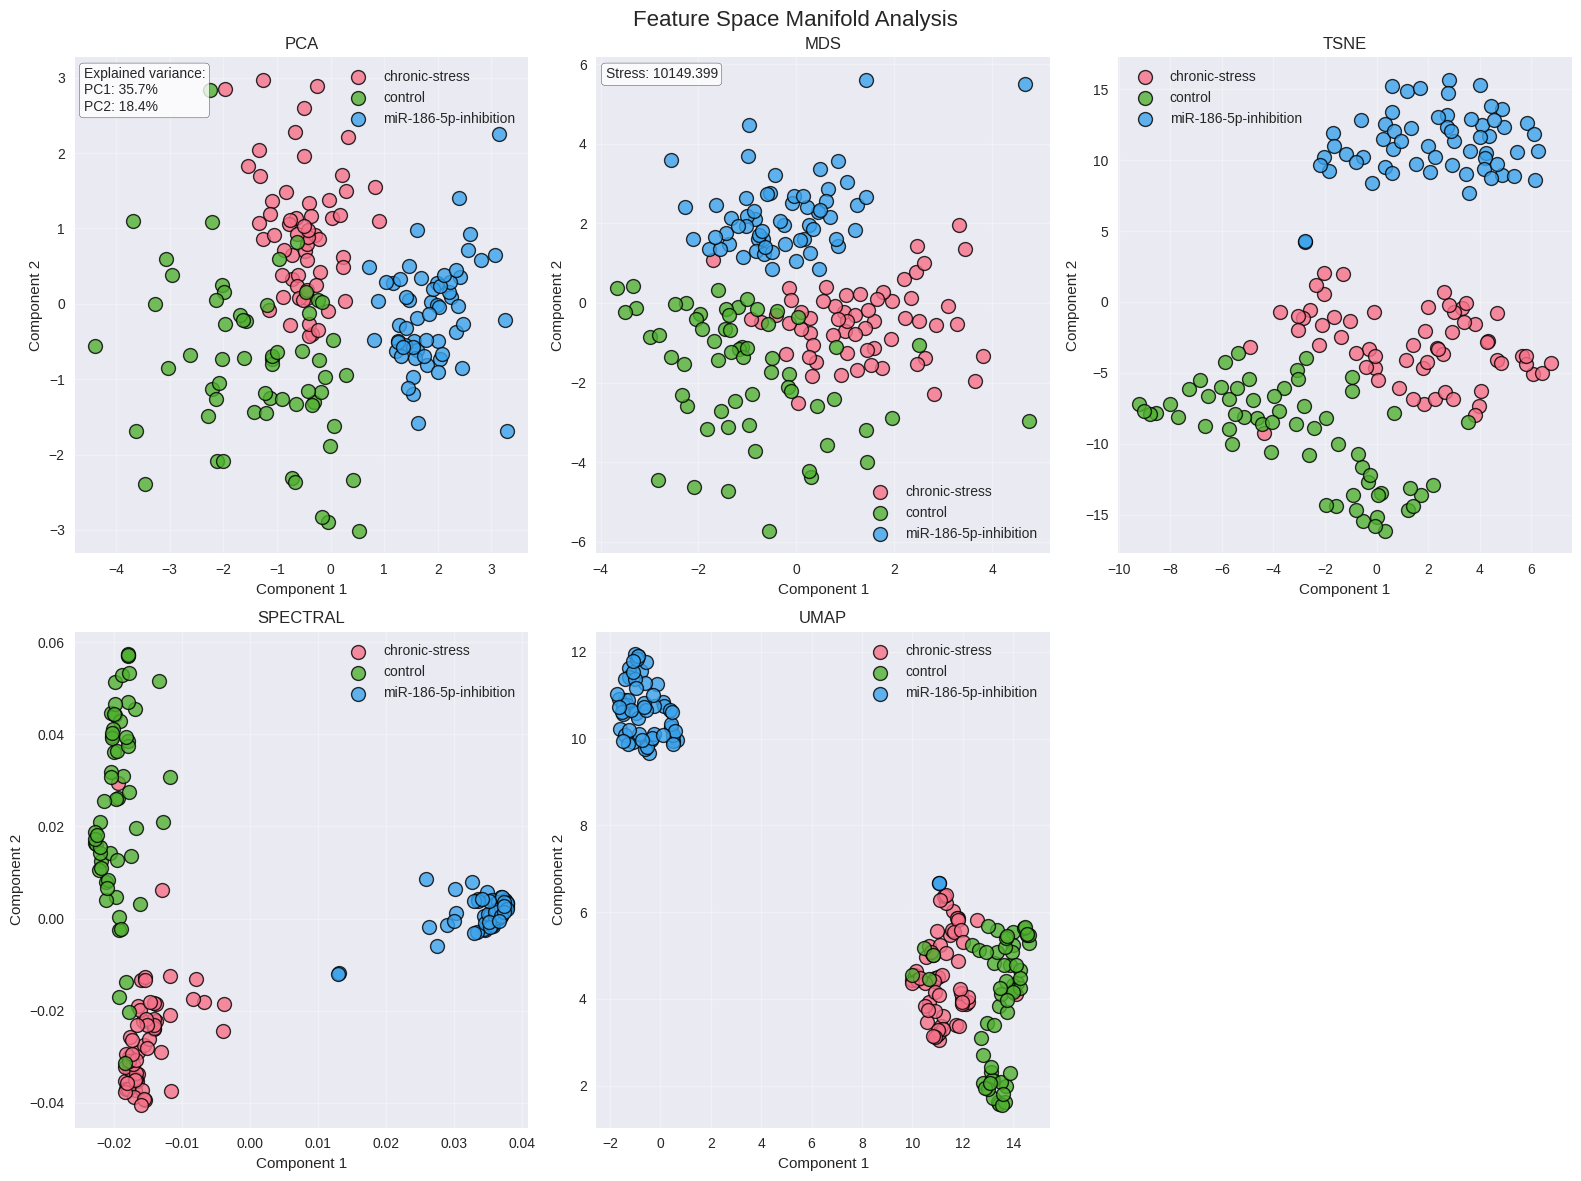

In [19]:
print(f"\nFiltered dataset: {df_critical.shape[0]} samples × {df_critical.shape[1]-1} features")

# Feature space analysis using existing MEA-Flow function
print("\n🔬 Feature space analysis on critical features...")
manifold_results = analyze_feature_space(
    csv_path=filtered_path,
    condition_column='condition',
    methods=['PCA', 'MDS', 'TSNE', 'SPECTRAL', 'UMAP'],
    n_components=2,
    figsize=(16, 12),
    save_path='./testing/critical_features_manifold.png'
)


Clustering analysis on critical features...
=== Feature Space Clustering Analysis ===
Data shape: (180, 7) (180 samples, 7 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Applying KMEANS...
Applying GMM...
Applying DBSCAN...
Applying HIERARCHICAL...

=== Clustering Analysis Summary ===
Number of features: 7
Number of samples: 180
True conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Target clusters: 3

=== Method Comparison ===
 n_clusters    inertia  n_iter  silhouette_score  calinski_harabasz_score  davies_bouldin_score       method  adjusted_rand_score  normalized_mutual_info         aic         bic  log_likelihood converged  n_noise_points  noise_ratio  n_leaves  n_connected_components
          3 794.808155     9.0          0.257594                51.798007              1.387934       KMEANS             0.542302                0.650982         NaN         NaN             NaN       NaN             NaN          NaN       NaN               

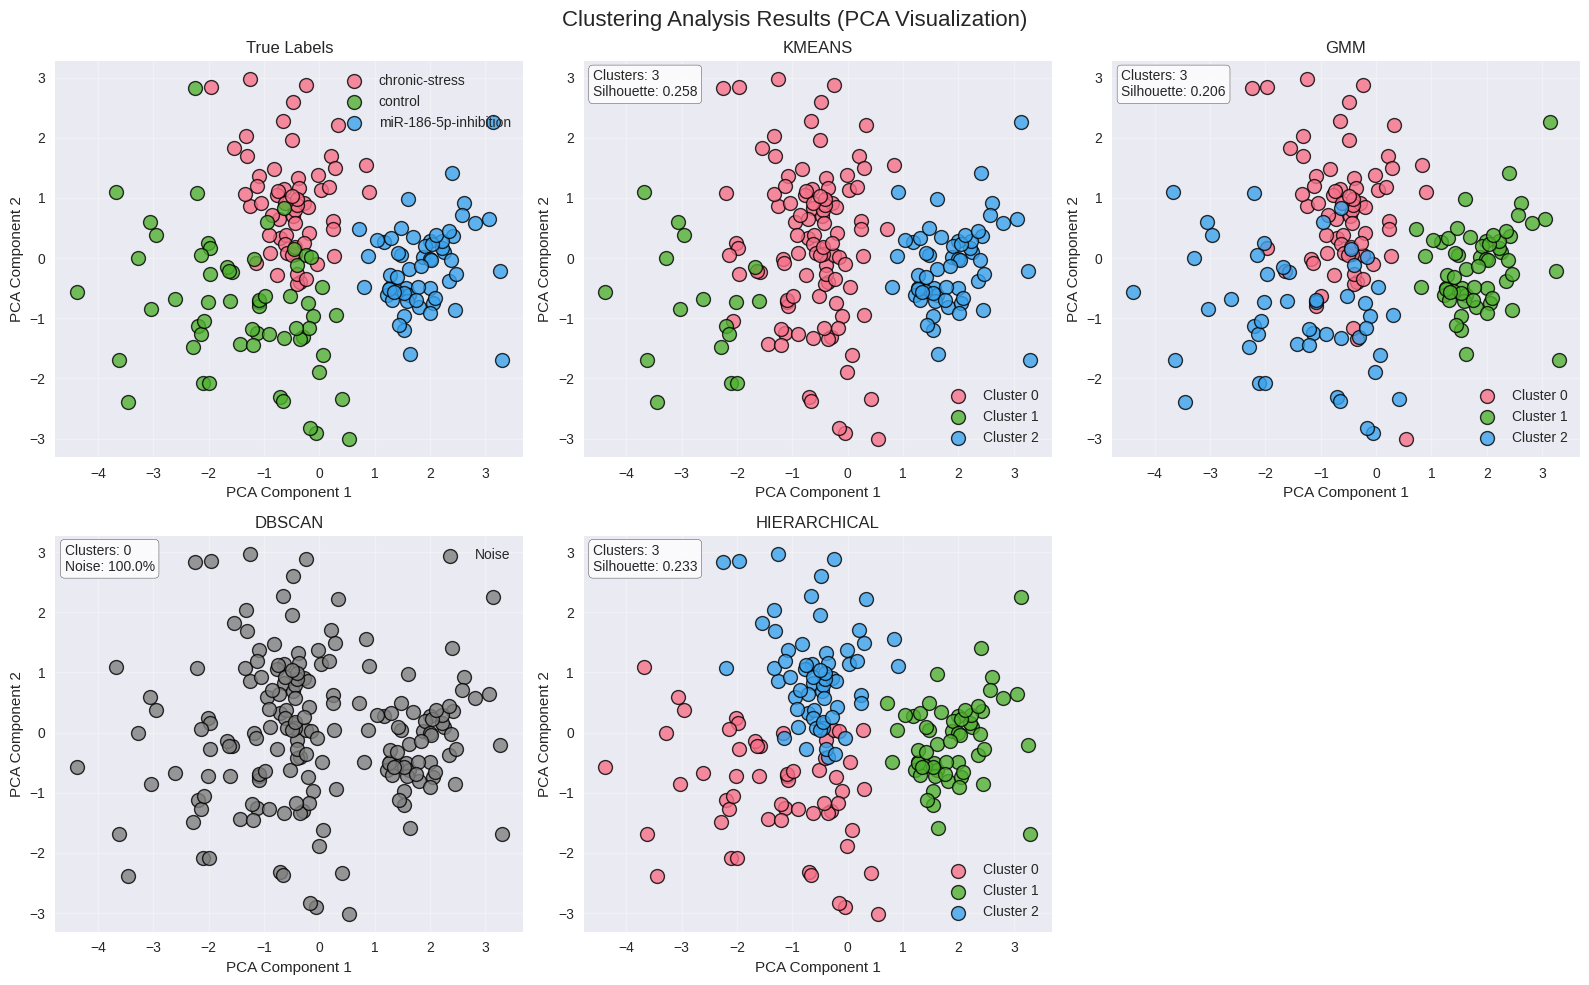

In [20]:
# Clustering analysis on critical features
print("\nClustering analysis on critical features...")
n_clusters = data['condition'].nunique()  # Number of conditions
clustering_results = analyze_clustering(
    csv_path=filtered_path,
    condition_column='condition',
    methods=['KMEANS', 'GMM', 'DBSCAN', 'HIERARCHICAL'],
    n_clusters=n_clusters,
    embedding_method='PCA',
    figsize=(16, 10),
    save_path='critical_features_clustering.png'
)


📊 Metrics comparison for critical features...


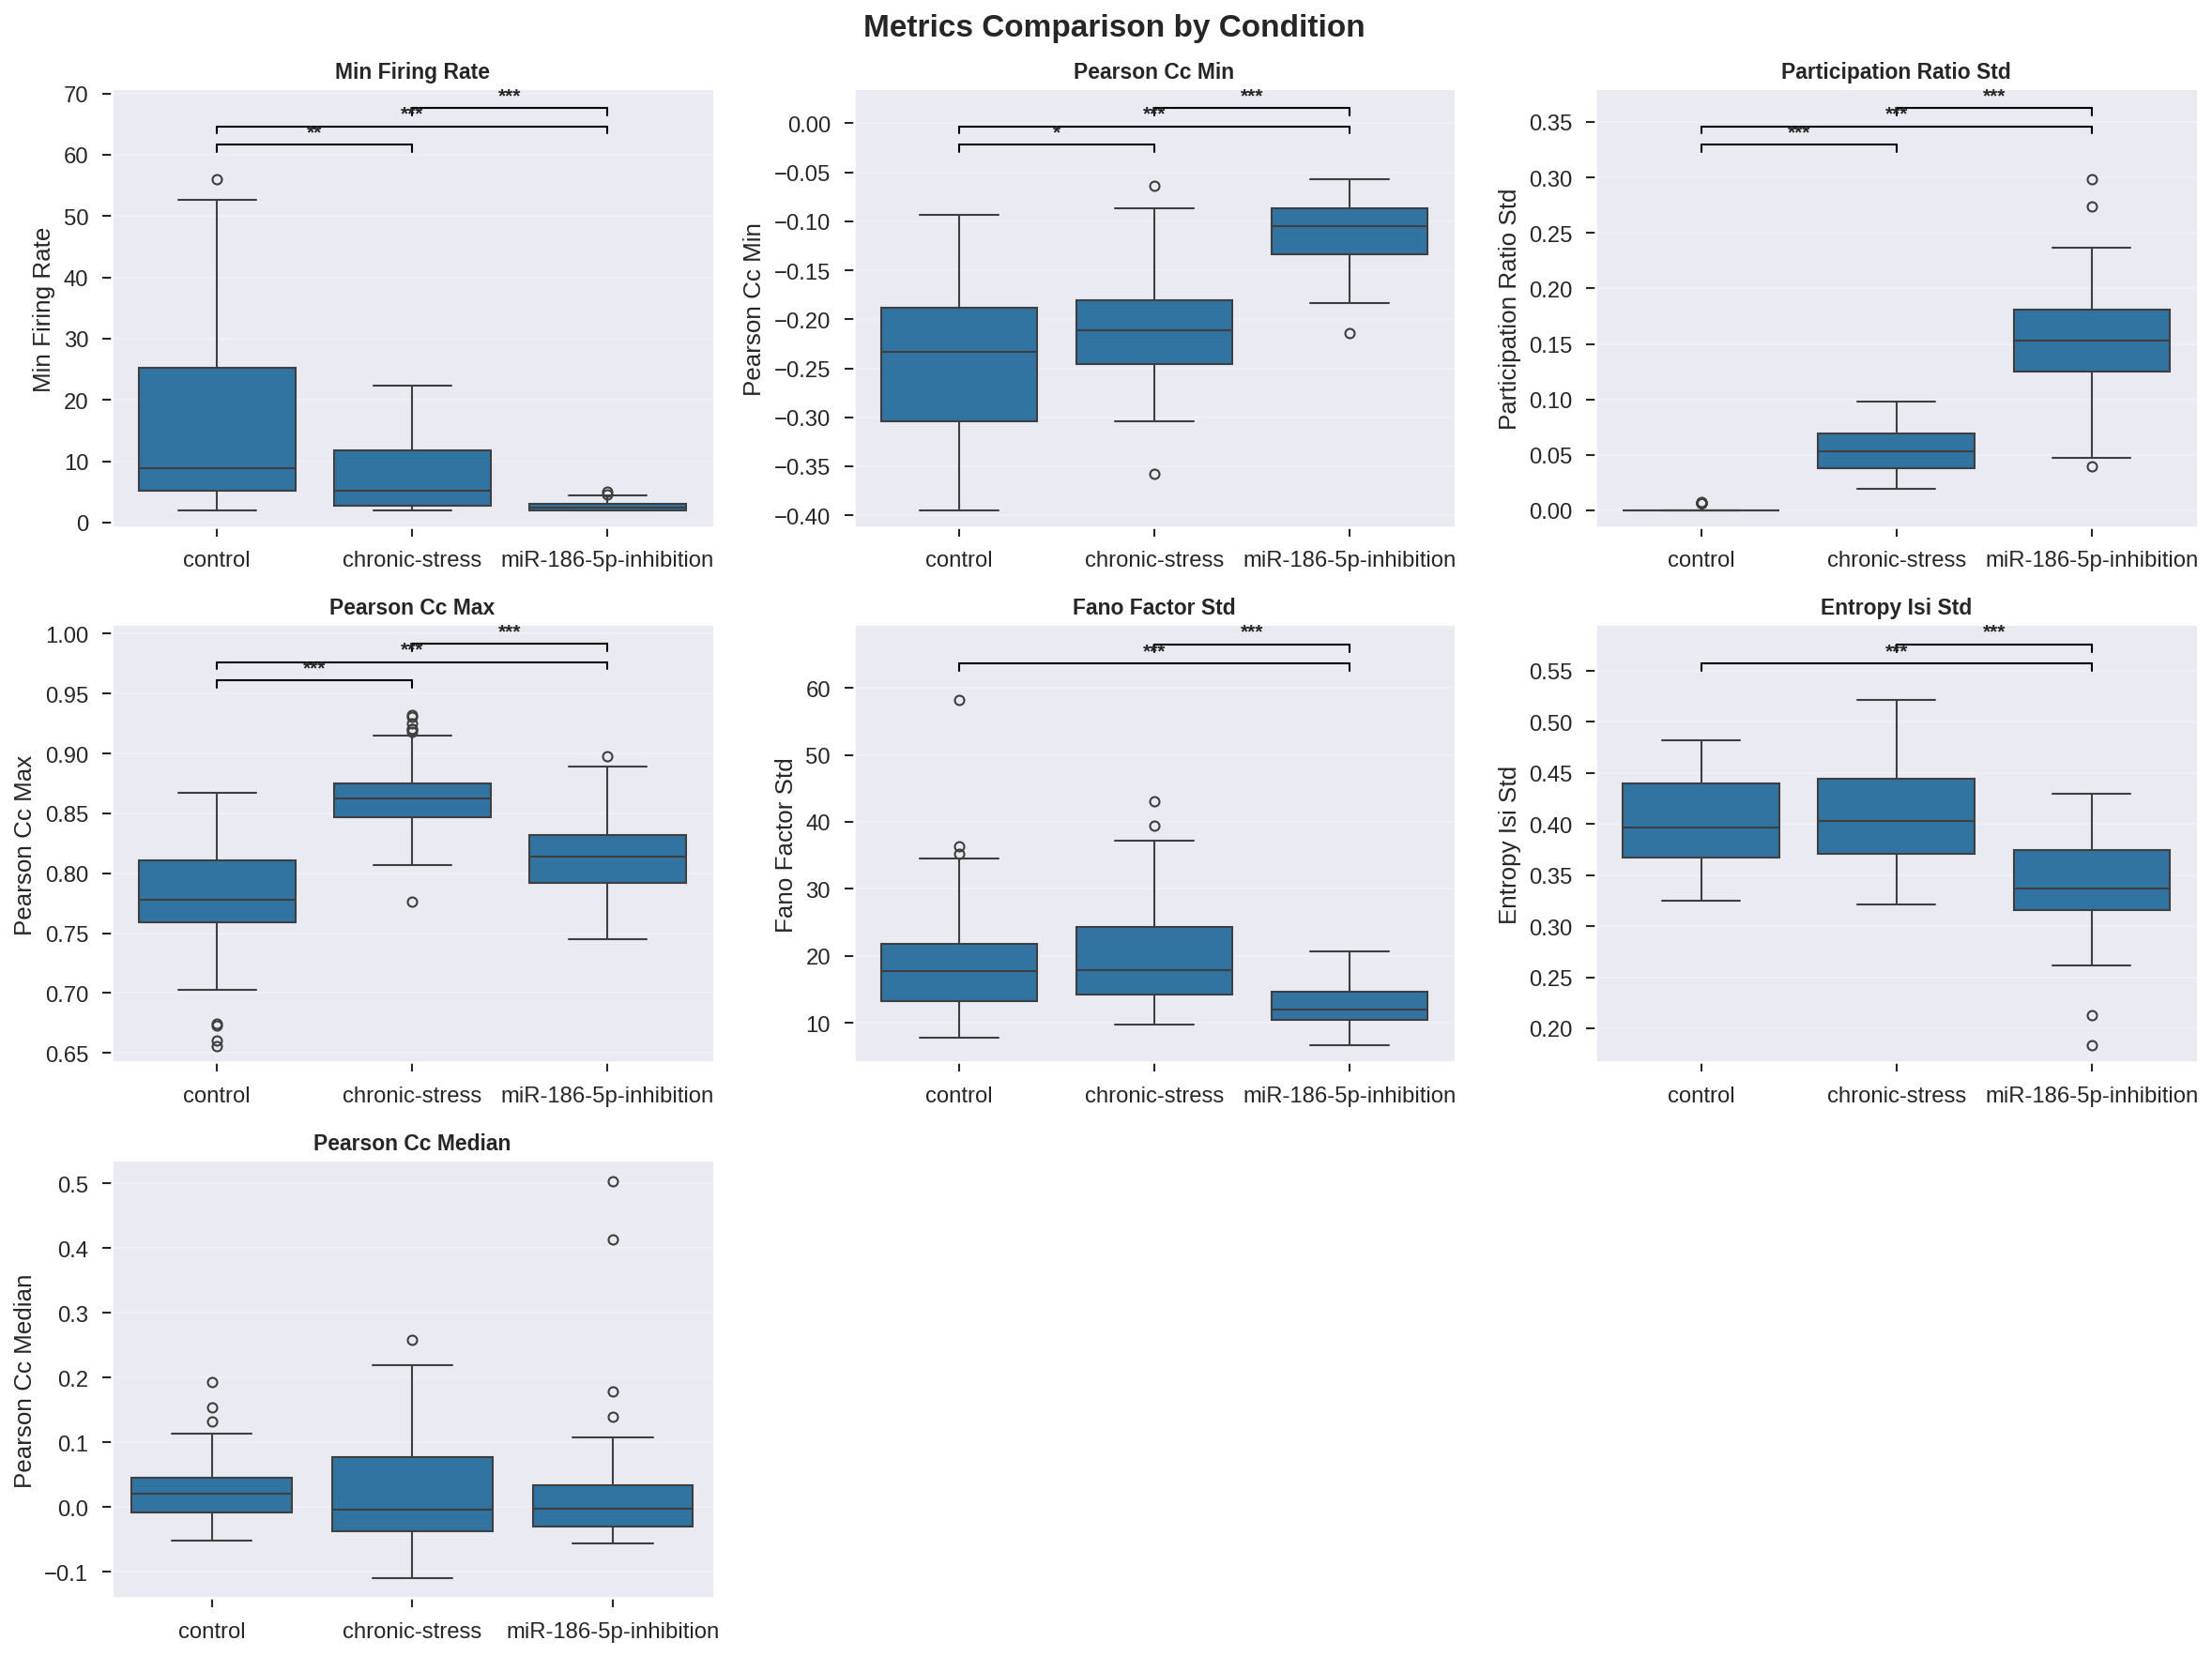

In [21]:
from mea_flow.visualization import MEAPlotter

plotter = MEAPlotter()

# Direct metrics comparison on critical features only
print("\n📊 Metrics comparison for critical features...")
plotter = MEAPlotter()
fig = plotter.plot_metrics_comparison(
    metrics_df=df_critical,
    group_by='condition',
    metrics=critical_features,  # Only plot the critical features
    figsize=(16, 12)
)
plt.savefig('./testing/critical_features_metrics.png', dpi=300, bbox_inches='tight')
plt.show()